# Peptides encoding (One-hot)

In [1]:
import peptides
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from datetime import date
import seaborn as sns
from math import sqrt

# libs for ml
import os
import torch
import torch.nn as nn
import torch.nn.functional as F

# my module with some func
import pepcode

## Preparing data

Set parameters: 

In [2]:
AA_LIST = pepcode.AA_LIST

Load training dataset:

In [3]:
pep_train_list = []
with open("./dataset/train_cdr3.txt") as file:
    for pep in file:
        pep = pep[:-1]
        pep_train_list.append(pep)

len_seq = len(pep_train_list[0])

pep_train_oh = np.zeros((len(pep_train_list), len(pepcode.AA_LIST), len_seq), dtype = np.float32)
for i in range(len(pep_train_list)):
    pep_train_oh[i] = pepcode.one_hot_code(pep_train_list[i])

Load evaluation dataset:

In [4]:
pep_eval_list = []
with open("./dataset/eval_cdr3.txt") as file:
    for pep in file:
        pep = pep[:-1]
        pep_eval_list.append(pep)

pep_eval_oh = np.zeros((len(pep_eval_list), len(pepcode.AA_LIST), len_seq), dtype = np.float32)
for i in range(len(pep_eval_list)):
    pep_eval_oh[i] = pepcode.one_hot_code(pep_eval_list[i])

Load test dataset:

In [5]:
pep_test_list = []
with open("./dataset/test_cdr3.txt") as file:
    for pep in file:
        pep = pep[:-1]
        pep_test_list.append(pep)

pep_test_oh = np.zeros((len(pep_test_list), len(pepcode.AA_LIST), len_seq), dtype = np.float32)
for i in range(len(pep_test_list)):
    pep_test_oh[i] = pepcode.one_hot_code(pep_test_list[i])

## Set parameters for ml

In [6]:
latent_dims = 200
num_epochs = 150 
batch_size = int(round(len(pep_train_list)/6))
learning_rate = 1e-3 
use_gpu = True

oh_matr_size = pep_test_oh[0].size

# Device set
if use_gpu and torch.cuda.is_available():
    device = torch.device("cuda:0")
elif use_gpu and torch.backends.mps.is_available():
    device = torch.device("mps")
else:
    device = torch.device("cpu")

### Loading datasets

In [7]:
# Train dataset
oh_dataset_train = torch.utils.data.TensorDataset(torch.tensor(pep_train_oh), torch.tensor(np.ones(pep_train_oh.shape[0])))
oh_dl_train = torch.utils.data.DataLoader(oh_dataset_train, batch_size=batch_size, shuffle=True)

# Eval dataset
oh_dataset_eval = torch.utils.data.TensorDataset(torch.tensor(pep_eval_oh), torch.tensor(np.ones(pep_eval_oh.shape[0])))
oh_dl_eval = torch.utils.data.DataLoader(oh_dataset_train, batch_size=batch_size, shuffle=True)

# Test dataset
oh_dataset_test = torch.utils.data.TensorDataset(torch.tensor(pep_test_oh), torch.tensor(np.ones(pep_test_oh.shape[0])))
oh_dl_test = torch.utils.data.DataLoader(oh_dataset_test, batch_size=batch_size, shuffle=True)


## Autoencoder_1 definition (315->50)

In [8]:
numb = 1
autoencoder_arch = '315->50'

class Encoder(nn.Module):
    def __init__(self):
        super(Encoder, self).__init__()
        self.fc1 = nn.Linear(in_features=len(AA_LIST)*len_seq, out_features=50)
            
    def forward(self, x):
        x = self.fc1(x)
        return x

class Decoder(nn.Module):
    def __init__(self):
        super(Decoder, self).__init__()
        self.fc1 = nn.Linear(in_features=50, out_features=len(AA_LIST)*len_seq)
            
    def forward(self, x):
        x = self.fc1(x)
        x = F.sigmoid(x)
        return x
    
class Autoencoder(nn.Module):
    def __init__(self):
        super(Autoencoder, self).__init__()
        self.encoder = Encoder()
        self.decoder = Decoder()
    
    def forward(self, x):
        latent = self.encoder(x)
        x_recon = self.decoder(latent)
        return x_recon
    
autoencoder_1 = Autoencoder()

autoencoder_1 = autoencoder_1.to(device)

num_params = sum(p.numel() for p in autoencoder_1.parameters() if p.requires_grad)
print('Number of parameters for One-hot encoding: %d' % num_params)

loss_function = nn.MSELoss()

optimizer = torch.optim.Adam(autoencoder_1.parameters(), lr = learning_rate, weight_decay = 1e-5)

Number of parameters for One-hot encoding: 30350


### Train autoencoder

In [9]:
# set to training mode
autoencoder_1.train()

train_loss_avg_1 = []

print('Training ...')
for epoch in range(num_epochs):
    train_loss_avg_1.append(0)
    num_batches = 0
    
    for pep_batch, _ in oh_dl_train:
        
        pep_batch = pep_batch.to(device)

        pep_batch = pep_batch.reshape(-1, oh_matr_size)
        
        # autoencoder reconstruction
        pep_batch_recon = autoencoder_1(pep_batch)
        
        # reconstruction error
        loss = loss_function(pep_batch_recon, pep_batch)
        
        # backpropagation
        optimizer.zero_grad()
        loss.backward()
        
        # one step of the optmizer (using the gradients from backpropagation)
        optimizer.step()
        
        train_loss_avg_1[-1] += loss.item()
        num_batches += 1
        
    train_loss_avg_1[-1] /= num_batches
    if epoch % 10 == 0:
        print('Epoch [%d / %d] average reconstruction error: %f' % (epoch+1, num_epochs, train_loss_avg_1[-1]))
print('Train finished')

Training ...
Epoch [1 / 150] average reconstruction error: 0.246877
Epoch [11 / 150] average reconstruction error: 0.029981
Epoch [21 / 150] average reconstruction error: 0.028080
Epoch [31 / 150] average reconstruction error: 0.027878
Epoch [41 / 150] average reconstruction error: 0.027021
Epoch [51 / 150] average reconstruction error: 0.025809
Epoch [61 / 150] average reconstruction error: 0.025062
Epoch [71 / 150] average reconstruction error: 0.023633
Epoch [81 / 150] average reconstruction error: 0.022645
Epoch [91 / 150] average reconstruction error: 0.021740
Epoch [101 / 150] average reconstruction error: 0.021025
Epoch [111 / 150] average reconstruction error: 0.018821
Epoch [121 / 150] average reconstruction error: 0.020317
Epoch [131 / 150] average reconstruction error: 0.017709
Epoch [141 / 150] average reconstruction error: 0.017774
Train finished


### Evaluation

In [10]:
autoencoder_1.eval()

output = []
test_loss_avg_1, num_batches = 0, 0

# Прогоняем тестовую выборку через автоэнкодер
for (pep, _) in oh_dl_test:
    with torch.no_grad():
        pep = pep.reshape(-1, oh_matr_size)
        pep = pep.to(device)
        pep_recon = autoencoder_1(pep)
        loss = loss_function(pep_recon, pep)
        test_loss_avg_1 += loss.item()
        num_batches += 1
    output.append((pep, pep_recon))
test_loss_avg_1 /= num_batches


test_loss_avg_1 /= num_batches
print('Average reconstruction error: %f' % (test_loss_avg_1))

# Output выглядит странно это лист, состоящий из кортежей, каждый из которых относится к одному батчу. Т.е. ouput[0] - это кортеж из первого батча
# Далее каждый кортеж, состоит из двух тензоров: до и после энкодера. Тензоры в 2д формате.


# Создаём пустые(нулевые) массивы для one-hot петпидов до и после
pep_test_oh_bef = np.zeros((len(pep_test_list), len(pepcode.AA_LIST), len_seq), dtype = np.float32)
pep_test_oh_aft = np.zeros((len(pep_test_list), len(pepcode.AA_LIST), len_seq), dtype = np.float32)


# Переводим пептиды в np массив из output
pointer = 0
for i in range(num_batches):
    cur_batch_size = len(output[i][0])
    pep_test_oh_bef[pointer:pointer + cur_batch_size, :, : ] = output[i][0].reshape((cur_batch_size, len(AA_LIST), len_seq)).numpy(force=True)
    pep_test_oh_aft[pointer:pointer + cur_batch_size, :, : ] = output[i][1].reshape((cur_batch_size, len(AA_LIST), len_seq)).numpy(force=True)
    pointer += cur_batch_size
    

# Для каждого пептида после автоэнкодера приводим его к формату one-hot путем простанови 1 на место максимального веса в столбце
for i in range(pep_test_oh_aft.shape[0]):
    for j in range(len_seq):
        col_max = np.max(pep_test_oh_aft[i][:,j])
        for k in range(len(AA_LIST)):
            if pep_test_oh_aft[i][k][j] == col_max:
                pep_test_oh_aft[i][k][j] = 1.0
            else: 
                pep_test_oh_aft[i][k][j] = 0.0  

pep_test_list_bef_ae = []
pep_test_list_aft_ae = []

for i in range(pep_test_oh_aft.shape[0]):
    pep_test_list_bef_ae.append(pepcode.one_hot_decode(pep_test_oh_bef[i]))   
    pep_test_list_aft_ae.append(pepcode.one_hot_decode(pep_test_oh_aft[i]))

Average reconstruction error: 0.010318


### Biological evaluatiuon

In [11]:
err_count = np.zeros(len_seq, dtype = np.float32)
blos_score = np.zeros(len_seq, dtype = np.float32)

for i in range(len(pep_test_list_bef_ae)):
    for j in range(len_seq):
        if pep_test_list_bef_ae[i][j] != pep_test_list_aft_ae[i][j]:
            err_count[j] +=1
            blos_score[j] += pepcode.blosum_score(pep_test_list_bef_ae[i][j],pep_test_list_aft_ae[i][j])


avg_blos_score = {}
for i in range(len_seq):
    if err_count[i] !=0:
        avg_blos_score[i]=blos_score[i]/err_count[i]

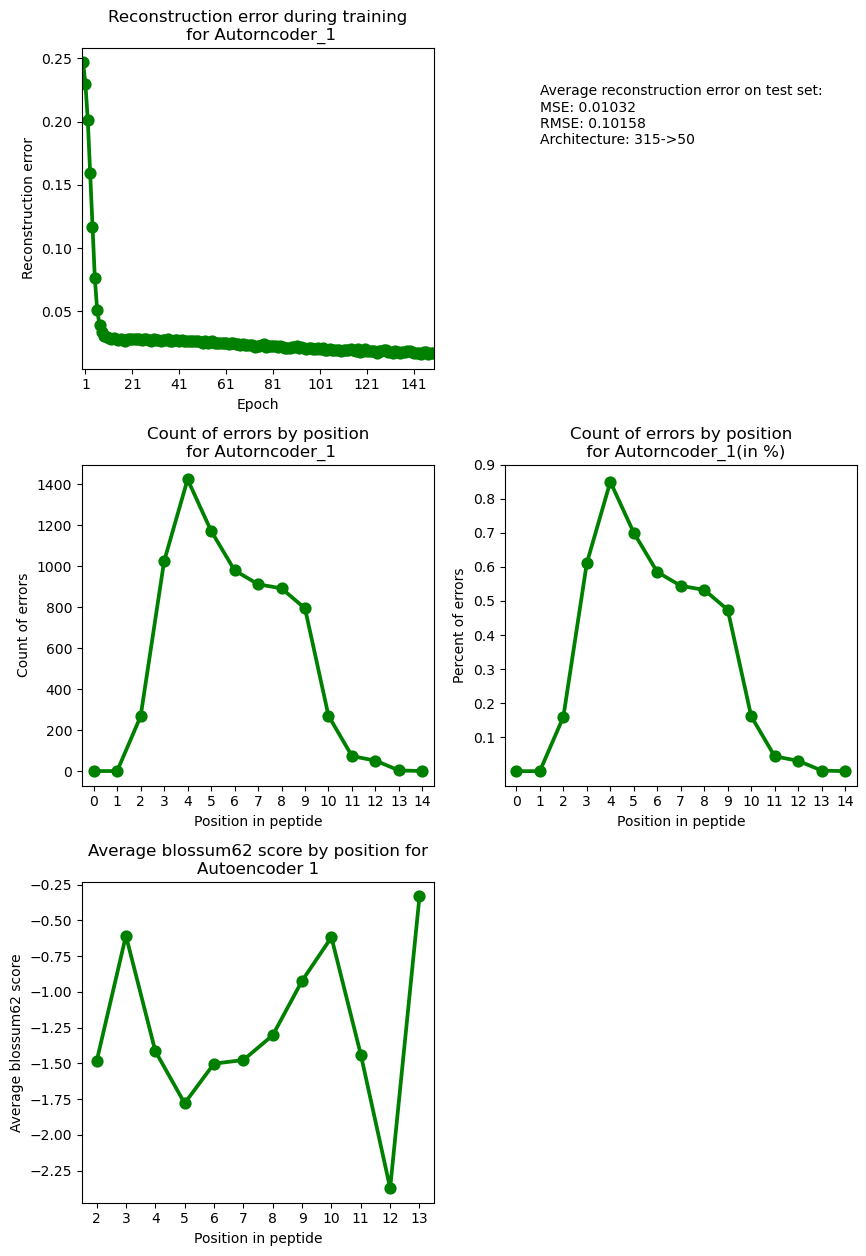

In [12]:
fig, axs = plt.subplots(3,2, figsize = [10, 15])
sns.pointplot(train_loss_avg_1, color = 'green', ax=axs[0, 0])
sns.pointplot(err_count, color = 'green', ax=axs[1, 0])
sns.pointplot(err_count/len(pep_test_list_bef_ae), color = 'green', ax=axs[1, 1])
axs[0, 0].set(xlabel='Epoch', ylabel='Reconstruction error', title = 'Reconstruction error during training\n for Autorncoder_1', xticks=[i for i in range(1, num_epochs, 20)])
axs[0, 1].set(frame_on=False)
axs[0, 1].set_xticks([])
axs[0, 1].set_yticks([])
axs[0, 1].text(x=0.1, y=0.7, s=f'Average reconstruction error on test set:\nMSE: {round(test_loss_avg_1, 5)}\nRMSE: {round(sqrt(test_loss_avg_1), 5)}\nArchitecture: {autoencoder_arch}')
axs[1, 0].set(xlabel='Position in peptide', ylabel='Count of errors', title='Count of errors by position\n for Autorncoder_1')
axs[1, 1].set(xlabel='Position in peptide', ylabel='Percent of errors', title='Count of errors by position\n  for Autorncoder_1(in %)', yticks=[i/10 for i in range(1, 10)])
sns.pointplot(x=avg_blos_score.keys(), y=avg_blos_score.values(), color='green', ax=axs[2,0])
axs[2, 0].set(xlabel='Position in peptide', ylabel='Average blossum62 score', title='Average blossum62 score by position for\nAutoencoder 1')
plt.subplots_adjust(wspace=0.2, hspace=0.3)
axs[2, 1].set(frame_on=False)
axs[2, 1].set_xticks([])
axs[2, 1].set_yticks([])
plt.show()
fig.savefig(f'./Results_one_hot/{numb}_{str(date.today())}_test_{autoencoder_arch}.pdf', format='pdf')


In [13]:
print('Average blossum score: ', sum(pepcode.blosum62.values())/len(pepcode.blosum62.values()))
print('Minimum blossum score in table:', min(pepcode.blosum62.values()))

Average blossum score:  -1.0276679841897234
Minimum blossum score in table: -4


## Autoencoder_2 definition (315->100)

In [14]:
numb += 1
autoencoder_arch = '315->100'

class Encoder(nn.Module):
    def __init__(self):
        super(Encoder, self).__init__()
        self.fc1 = nn.Linear(in_features=len(AA_LIST)*len_seq, out_features=100)
            
    def forward(self, x):
        x = self.fc1(x)
        return x

class Decoder(nn.Module):
    def __init__(self):
        super(Decoder, self).__init__()
        self.fc1 = nn.Linear(in_features=100, out_features=len(AA_LIST)*len_seq)
            
    def forward(self, x):
        x = self.fc1(x)
        x = F.sigmoid(x)
        return x
    
class Autoencoder(nn.Module):
    def __init__(self):
        super(Autoencoder, self).__init__()
        self.encoder = Encoder()
        self.decoder = Decoder()
    
    def forward(self, x):
        latent = self.encoder(x)
        x_recon = self.decoder(latent)
        return x_recon
    
autoencoder_1 = Autoencoder()

autoencoder_1 = autoencoder_1.to(device)

num_params = sum(p.numel() for p in autoencoder_1.parameters() if p.requires_grad)
print('Number of parameters for One-hot encoding: %d' % num_params)

loss_function = nn.MSELoss()

optimizer = torch.optim.Adam(autoencoder_1.parameters(), lr = learning_rate, weight_decay = 1e-5)

Number of parameters for One-hot encoding: 60400


### Train autoencoder

In [15]:
# set to training mode
autoencoder_1.train()

train_loss_avg_1 = []

print('Training ...')
for epoch in range(num_epochs):
    train_loss_avg_1.append(0)
    num_batches = 0
    
    for pep_batch, _ in oh_dl_train:
        
        pep_batch = pep_batch.to(device)

        pep_batch = pep_batch.reshape(-1, oh_matr_size)
        
        # autoencoder reconstruction
        pep_batch_recon = autoencoder_1(pep_batch)
        
        # reconstruction error
        loss = loss_function(pep_batch_recon, pep_batch)
        
        # backpropagation
        optimizer.zero_grad()
        loss.backward()
        
        # one step of the optmizer (using the gradients from backpropagation)
        optimizer.step()
        
        train_loss_avg_1[-1] += loss.item()
        num_batches += 1
        
    train_loss_avg_1[-1] /= num_batches
    if epoch % 10 == 0:
        print('Epoch [%d / %d] average reconstruction error: %f' % (epoch+1, num_epochs, train_loss_avg_1[-1]))
print('Train finished')

Training ...
Epoch [1 / 150] average reconstruction error: 0.239983
Epoch [11 / 150] average reconstruction error: 0.029347
Epoch [21 / 150] average reconstruction error: 0.026829
Epoch [31 / 150] average reconstruction error: 0.025415
Epoch [41 / 150] average reconstruction error: 0.025188
Epoch [51 / 150] average reconstruction error: 0.023196
Epoch [61 / 150] average reconstruction error: 0.022087
Epoch [71 / 150] average reconstruction error: 0.019928
Epoch [81 / 150] average reconstruction error: 0.018954
Epoch [91 / 150] average reconstruction error: 0.016326
Epoch [101 / 150] average reconstruction error: 0.016608
Epoch [111 / 150] average reconstruction error: 0.014766
Epoch [121 / 150] average reconstruction error: 0.014679
Epoch [131 / 150] average reconstruction error: 0.014301
Epoch [141 / 150] average reconstruction error: 0.013959
Train finished


### Evaluation

In [16]:
autoencoder_1.eval()

output = []
test_loss_avg_1, num_batches = 0, 0

# Прогоняем тестовую выборку через автоэнкодер
for (pep, _) in oh_dl_test:
    with torch.no_grad():
        pep = pep.reshape(-1, oh_matr_size)
        pep = pep.to(device)
        pep_recon = autoencoder_1(pep)
        loss = loss_function(pep_recon, pep)
        test_loss_avg_1 += loss.item()
        num_batches += 1
    output.append((pep, pep_recon))
test_loss_avg_1 /= num_batches


test_loss_avg_1 /= num_batches
print('Average reconstruction error: %f' % (test_loss_avg_1))

# Output выглядит странно это лист, состоящий из кортежей, каждый из которых относится к одному батчу. Т.е. ouput[0] - это кортеж из первого батча
# Далее каждый кортеж, состоит из двух тензоров: до и после энкодера. Тензоры в 2д формате.


# Создаём пустые(нулевые) массивы для one-hot петпидов до и после
pep_test_oh_bef = np.zeros((len(pep_test_list), len(pepcode.AA_LIST), len_seq), dtype = np.float32)
pep_test_oh_aft = np.zeros((len(pep_test_list), len(pepcode.AA_LIST), len_seq), dtype = np.float32)


# Переводим пептиды в np массив из output
pointer = 0
for i in range(num_batches):
    cur_batch_size = len(output[i][0])
    pep_test_oh_bef[pointer:pointer + cur_batch_size, :, : ] = output[i][0].reshape((cur_batch_size, len(AA_LIST), len_seq)).numpy(force=True)
    pep_test_oh_aft[pointer:pointer + cur_batch_size, :, : ] = output[i][1].reshape((cur_batch_size, len(AA_LIST), len_seq)).numpy(force=True)
    pointer += cur_batch_size
    

# Для каждого пептида после автоэнкодера приводим его к формату one-hot путем простанови 1 на место максимального веса в столбце
for i in range(pep_test_oh_aft.shape[0]):
    for j in range(len_seq):
        col_max = np.max(pep_test_oh_aft[i][:,j])
        for k in range(len(AA_LIST)):
            if pep_test_oh_aft[i][k][j] == col_max:
                pep_test_oh_aft[i][k][j] = 1.0
            else: 
                pep_test_oh_aft[i][k][j] = 0.0  

pep_test_list_bef_ae = []
pep_test_list_aft_ae = []

for i in range(pep_test_oh_aft.shape[0]):
    pep_test_list_bef_ae.append(pepcode.one_hot_decode(pep_test_oh_bef[i]))   
    pep_test_list_aft_ae.append(pepcode.one_hot_decode(pep_test_oh_aft[i]))

Average reconstruction error: 0.008010


### Biological evaluatiuon

In [17]:
err_count = np.zeros(len_seq, dtype = np.float32)
blos_score = np.zeros(len_seq, dtype = np.float32)

for i in range(len(pep_test_list_bef_ae)):
    for j in range(len_seq):
        if pep_test_list_bef_ae[i][j] != pep_test_list_aft_ae[i][j]:
            err_count[j] +=1
            blos_score[j] += pepcode.blosum_score(pep_test_list_bef_ae[i][j],pep_test_list_aft_ae[i][j])


avg_blos_score = {}
for i in range(len_seq):
    if err_count[i] !=0:
        avg_blos_score[i]=blos_score[i]/err_count[i]

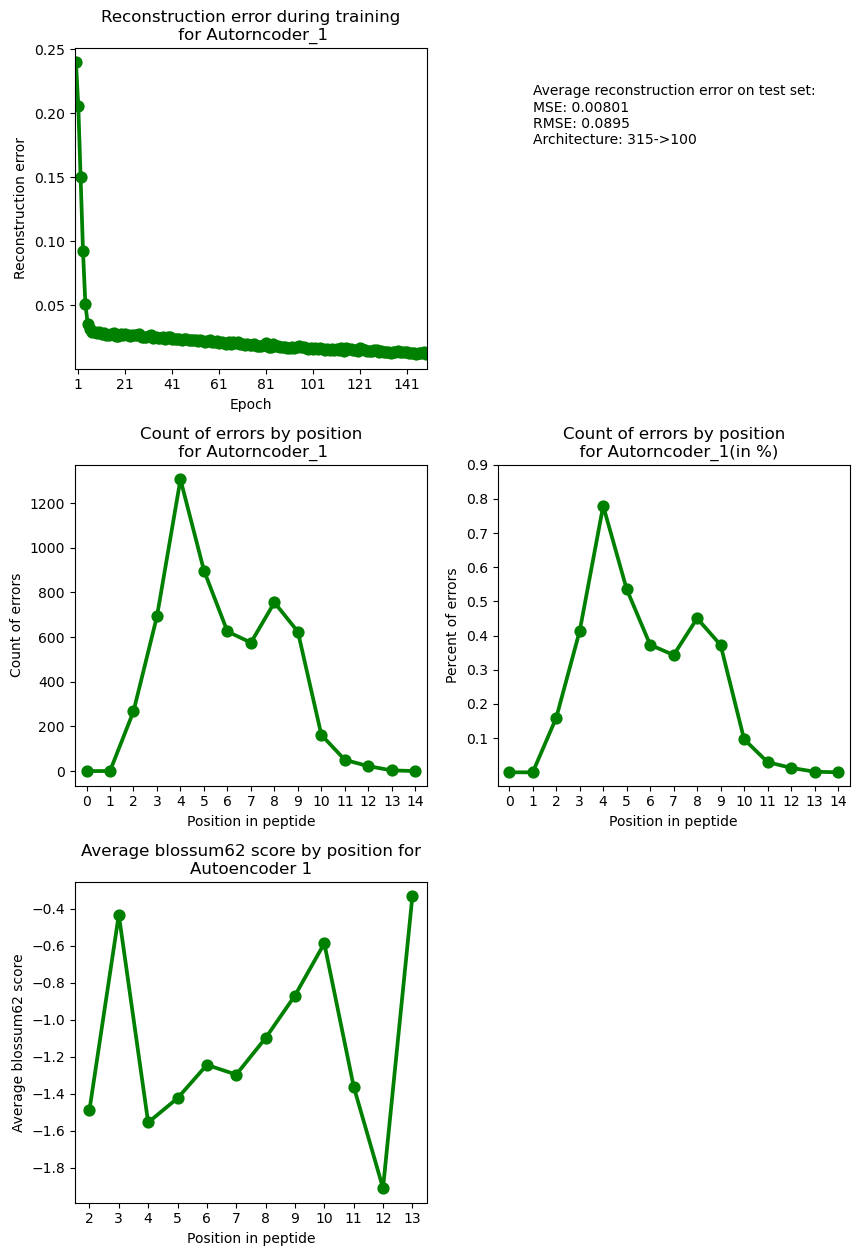

In [18]:
fig, axs = plt.subplots(3,2, figsize = [10, 15])
sns.pointplot(train_loss_avg_1, color = 'green', ax=axs[0, 0])
sns.pointplot(err_count, color = 'green', ax=axs[1, 0])
sns.pointplot(err_count/len(pep_test_list_bef_ae), color = 'green', ax=axs[1, 1])
axs[0, 0].set(xlabel='Epoch', ylabel='Reconstruction error', title = 'Reconstruction error during training\n for Autorncoder_1', xticks=[i for i in range(1, num_epochs, 20)])
axs[0, 1].set(frame_on=False)
axs[0, 1].set_xticks([])
axs[0, 1].set_yticks([])
axs[0, 1].text(x=0.1, y=0.7, s=f'Average reconstruction error on test set:\nMSE: {round(test_loss_avg_1, 5)}\nRMSE: {round(sqrt(test_loss_avg_1), 5)}\nArchitecture: {autoencoder_arch}')
axs[1, 0].set(xlabel='Position in peptide', ylabel='Count of errors', title='Count of errors by position\n for Autorncoder_1')
axs[1, 1].set(xlabel='Position in peptide', ylabel='Percent of errors', title='Count of errors by position\n  for Autorncoder_1(in %)', yticks=[i/10 for i in range(1, 10)])
sns.pointplot(x=avg_blos_score.keys(), y=avg_blos_score.values(), color='green', ax=axs[2,0])
axs[2, 0].set(xlabel='Position in peptide', ylabel='Average blossum62 score', title='Average blossum62 score by position for\nAutoencoder 1')
plt.subplots_adjust(wspace=0.2, hspace=0.3)
axs[2, 1].set(frame_on=False)
axs[2, 1].set_xticks([])
axs[2, 1].set_yticks([])
plt.show()
fig.savefig(f'./Results_one_hot/{numb}_{str(date.today())}_test_{autoencoder_arch}.pdf', format='pdf')


## Autoencoder_3 definition (315->200)

In [19]:
numb += 1
autoencoder_arch = '315->200'

class Encoder(nn.Module):
    def __init__(self):
        super(Encoder, self).__init__()
        self.fc1 = nn.Linear(in_features=len(AA_LIST)*len_seq, out_features=200)
            
    def forward(self, x):
        x = self.fc1(x)
        return x

class Decoder(nn.Module):
    def __init__(self):
        super(Decoder, self).__init__()
        self.fc1 = nn.Linear(in_features=200, out_features=len(AA_LIST)*len_seq)
            
    def forward(self, x):
        x = self.fc1(x)
        x = F.sigmoid(x)
        return x
    
class Autoencoder(nn.Module):
    def __init__(self):
        super(Autoencoder, self).__init__()
        self.encoder = Encoder()
        self.decoder = Decoder()
    
    def forward(self, x):
        latent = self.encoder(x)
        x_recon = self.decoder(latent)
        return x_recon
    
autoencoder_1 = Autoencoder()

autoencoder_1 = autoencoder_1.to(device)

num_params = sum(p.numel() for p in autoencoder_1.parameters() if p.requires_grad)
print('Number of parameters for One-hot encoding: %d' % num_params)

loss_function = nn.MSELoss()

optimizer = torch.optim.Adam(autoencoder_1.parameters(), lr = learning_rate, weight_decay = 1e-5)

Number of parameters for One-hot encoding: 120500


### Train autoencoder

In [20]:
# set to training mode
autoencoder_1.train()

train_loss_avg_1 = []

print('Training ...')
for epoch in range(num_epochs):
    train_loss_avg_1.append(0)
    num_batches = 0
    
    for pep_batch, _ in oh_dl_train:
        
        pep_batch = pep_batch.to(device)

        pep_batch = pep_batch.reshape(-1, oh_matr_size)
        
        # autoencoder reconstruction
        pep_batch_recon = autoencoder_1(pep_batch)
        
        # reconstruction error
        loss = loss_function(pep_batch_recon, pep_batch)
        
        # backpropagation
        optimizer.zero_grad()
        loss.backward()
        
        # one step of the optmizer (using the gradients from backpropagation)
        optimizer.step()
        
        train_loss_avg_1[-1] += loss.item()
        num_batches += 1
        
    train_loss_avg_1[-1] /= num_batches
    if epoch % 10 == 0:
        print('Epoch [%d / %d] average reconstruction error: %f' % (epoch+1, num_epochs, train_loss_avg_1[-1]))
print('Train finished')

Training ...
Epoch [1 / 150] average reconstruction error: 0.234458
Epoch [11 / 150] average reconstruction error: 0.026984
Epoch [21 / 150] average reconstruction error: 0.025351
Epoch [31 / 150] average reconstruction error: 0.022458
Epoch [41 / 150] average reconstruction error: 0.020238
Epoch [51 / 150] average reconstruction error: 0.018382
Epoch [61 / 150] average reconstruction error: 0.016653
Epoch [71 / 150] average reconstruction error: 0.017534
Epoch [81 / 150] average reconstruction error: 0.015127
Epoch [91 / 150] average reconstruction error: 0.013967
Epoch [101 / 150] average reconstruction error: 0.012501
Epoch [111 / 150] average reconstruction error: 0.011382
Epoch [121 / 150] average reconstruction error: 0.011388
Epoch [131 / 150] average reconstruction error: 0.009743
Epoch [141 / 150] average reconstruction error: 0.010220
Train finished


### Evaluation

In [21]:
autoencoder_1.eval()

output = []
test_loss_avg_1, num_batches = 0, 0

# Прогоняем тестовую выборку через автоэнкодер
for (pep, _) in oh_dl_test:
    with torch.no_grad():
        pep = pep.reshape(-1, oh_matr_size)
        pep = pep.to(device)
        pep_recon = autoencoder_1(pep)
        loss = loss_function(pep_recon, pep)
        test_loss_avg_1 += loss.item()
        num_batches += 1
    output.append((pep, pep_recon))
test_loss_avg_1 /= num_batches


test_loss_avg_1 /= num_batches
print('Average reconstruction error: %f' % (test_loss_avg_1))

# Output выглядит странно это лист, состоящий из кортежей, каждый из которых относится к одному батчу. Т.е. ouput[0] - это кортеж из первого батча
# Далее каждый кортеж, состоит из двух тензоров: до и после энкодера. Тензоры в 2д формате.


# Создаём пустые(нулевые) массивы для one-hot петпидов до и после
pep_test_oh_bef = np.zeros((len(pep_test_list), len(pepcode.AA_LIST), len_seq), dtype = np.float32)
pep_test_oh_aft = np.zeros((len(pep_test_list), len(pepcode.AA_LIST), len_seq), dtype = np.float32)


# Переводим пептиды в np массив из output
pointer = 0
for i in range(num_batches):
    cur_batch_size = len(output[i][0])
    pep_test_oh_bef[pointer:pointer + cur_batch_size, :, : ] = output[i][0].reshape((cur_batch_size, len(AA_LIST), len_seq)).numpy(force=True)
    pep_test_oh_aft[pointer:pointer + cur_batch_size, :, : ] = output[i][1].reshape((cur_batch_size, len(AA_LIST), len_seq)).numpy(force=True)
    pointer += cur_batch_size
    

# Для каждого пептида после автоэнкодера приводим его к формату one-hot путем простанови 1 на место максимального веса в столбце
for i in range(pep_test_oh_aft.shape[0]):
    for j in range(len_seq):
        col_max = np.max(pep_test_oh_aft[i][:,j])
        for k in range(len(AA_LIST)):
            if pep_test_oh_aft[i][k][j] == col_max:
                pep_test_oh_aft[i][k][j] = 1.0
            else: 
                pep_test_oh_aft[i][k][j] = 0.0  

pep_test_list_bef_ae = []
pep_test_list_aft_ae = []

for i in range(pep_test_oh_aft.shape[0]):
    pep_test_list_bef_ae.append(pepcode.one_hot_decode(pep_test_oh_bef[i]))   
    pep_test_list_aft_ae.append(pepcode.one_hot_decode(pep_test_oh_aft[i]))

Average reconstruction error: 0.005439


### Biological evaluatiuon

In [22]:
err_count = np.zeros(len_seq, dtype = np.float32)
blos_score = np.zeros(len_seq, dtype = np.float32)

for i in range(len(pep_test_list_bef_ae)):
    for j in range(len_seq):
        if pep_test_list_bef_ae[i][j] != pep_test_list_aft_ae[i][j]:
            err_count[j] +=1
            blos_score[j] += pepcode.blosum_score(pep_test_list_bef_ae[i][j],pep_test_list_aft_ae[i][j])


avg_blos_score = {}
for i in range(len_seq):
    if err_count[i] !=0:
        avg_blos_score[i]=blos_score[i]/err_count[i]

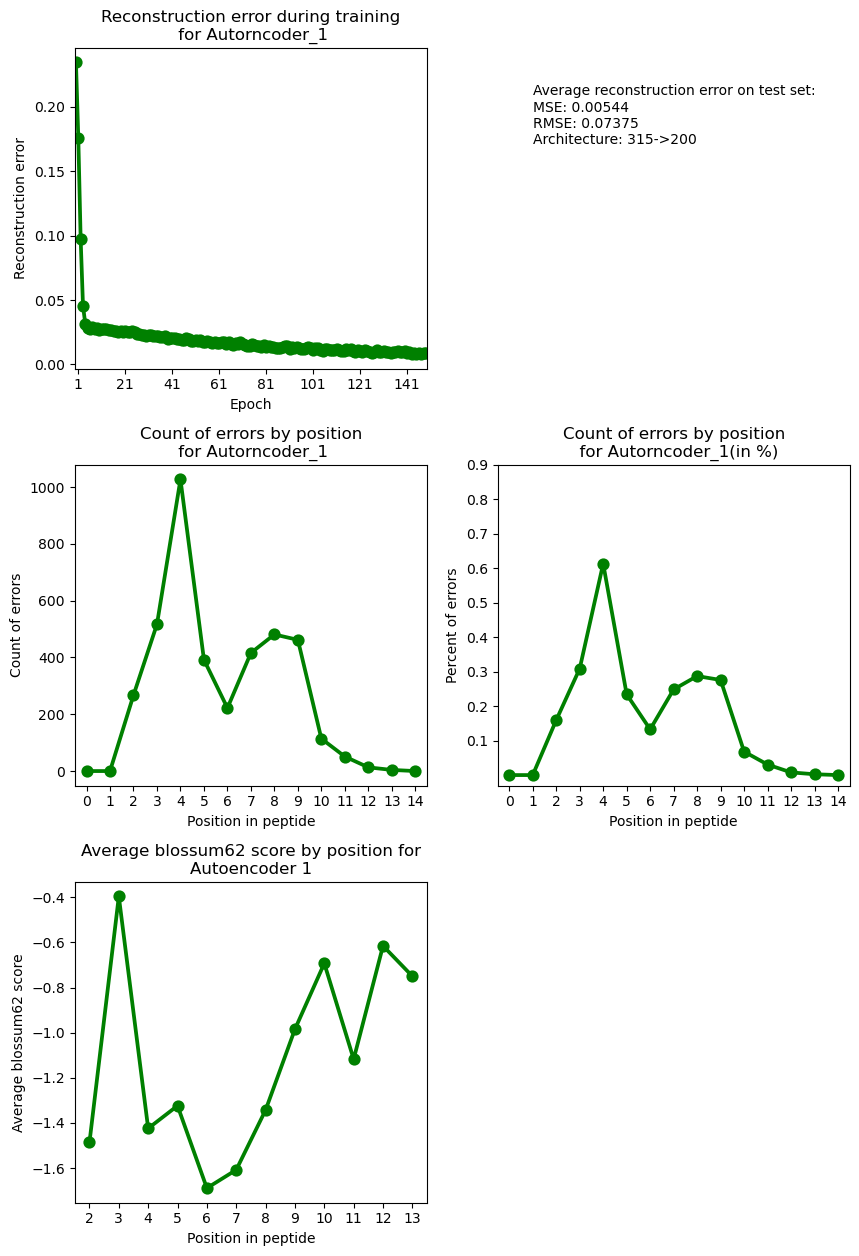

In [23]:
fig, axs = plt.subplots(3,2, figsize = [10, 15])
sns.pointplot(train_loss_avg_1, color = 'green', ax=axs[0, 0])
sns.pointplot(err_count, color = 'green', ax=axs[1, 0])
sns.pointplot(err_count/len(pep_test_list_bef_ae), color = 'green', ax=axs[1, 1])
axs[0, 0].set(xlabel='Epoch', ylabel='Reconstruction error', title = 'Reconstruction error during training\n for Autorncoder_1', xticks=[i for i in range(1, num_epochs, 20)])
axs[0, 1].set(frame_on=False)
axs[0, 1].set_xticks([])
axs[0, 1].set_yticks([])
axs[0, 1].text(x=0.1, y=0.7, s=f'Average reconstruction error on test set:\nMSE: {round(test_loss_avg_1, 5)}\nRMSE: {round(sqrt(test_loss_avg_1), 5)}\nArchitecture: {autoencoder_arch}')
axs[1, 0].set(xlabel='Position in peptide', ylabel='Count of errors', title='Count of errors by position\n for Autorncoder_1')
axs[1, 1].set(xlabel='Position in peptide', ylabel='Percent of errors', title='Count of errors by position\n  for Autorncoder_1(in %)', yticks=[i/10 for i in range(1, 10)])
sns.pointplot(x=avg_blos_score.keys(), y=avg_blos_score.values(), color='green', ax=axs[2,0])
axs[2, 0].set(xlabel='Position in peptide', ylabel='Average blossum62 score', title='Average blossum62 score by position for\nAutoencoder 1')
plt.subplots_adjust(wspace=0.2, hspace=0.3)
axs[2, 1].set(frame_on=False)
axs[2, 1].set_xticks([])
axs[2, 1].set_yticks([])
plt.show()
fig.savefig(f'./Results_one_hot/{numb}_{str(date.today())}_test_{autoencoder_arch}.pdf', format='pdf')


## Autoencoder_4 definition (315->300)

In [24]:
numb += 1
autoencoder_arch = '315->300'

class Encoder(nn.Module):
    def __init__(self):
        super(Encoder, self).__init__()
        self.fc1 = nn.Linear(in_features=len(AA_LIST)*len_seq, out_features=300)
            
    def forward(self, x):
        x = self.fc1(x)
        return x

class Decoder(nn.Module):
    def __init__(self):
        super(Decoder, self).__init__()
        self.fc1 = nn.Linear(in_features=300, out_features=len(AA_LIST)*len_seq)
            
    def forward(self, x):
        x = self.fc1(x)
        x = F.sigmoid(x)
        return x
    
class Autoencoder(nn.Module):
    def __init__(self):
        super(Autoencoder, self).__init__()
        self.encoder = Encoder()
        self.decoder = Decoder()
    
    def forward(self, x):
        latent = self.encoder(x)
        x_recon = self.decoder(latent)
        return x_recon
    
autoencoder_1 = Autoencoder()

autoencoder_1 = autoencoder_1.to(device)

num_params = sum(p.numel() for p in autoencoder_1.parameters() if p.requires_grad)
print('Number of parameters for One-hot encoding: %d' % num_params)

loss_function = nn.MSELoss()

optimizer = torch.optim.Adam(autoencoder_1.parameters(), lr = learning_rate, weight_decay = 1e-5)

Number of parameters for One-hot encoding: 180600


### Train autoencoder

In [25]:
# set to training mode
autoencoder_1.train()

train_loss_avg_1 = []

print('Training ...')
for epoch in range(num_epochs):
    train_loss_avg_1.append(0)
    num_batches = 0
    
    for pep_batch, _ in oh_dl_train:
        
        pep_batch = pep_batch.to(device)

        pep_batch = pep_batch.reshape(-1, oh_matr_size)
        
        # autoencoder reconstruction
        pep_batch_recon = autoencoder_1(pep_batch)
        
        # reconstruction error
        loss = loss_function(pep_batch_recon, pep_batch)
        
        # backpropagation
        optimizer.zero_grad()
        loss.backward()
        
        # one step of the optmizer (using the gradients from backpropagation)
        optimizer.step()
        
        train_loss_avg_1[-1] += loss.item()
        num_batches += 1
        
    train_loss_avg_1[-1] /= num_batches
    if epoch % 10 == 0:
        print('Epoch [%d / %d] average reconstruction error: %f' % (epoch+1, num_epochs, train_loss_avg_1[-1]))
print('Train finished')

Training ...
Epoch [1 / 150] average reconstruction error: 0.224398
Epoch [11 / 150] average reconstruction error: 0.026060
Epoch [21 / 150] average reconstruction error: 0.023608
Epoch [31 / 150] average reconstruction error: 0.020274
Epoch [41 / 150] average reconstruction error: 0.019106
Epoch [51 / 150] average reconstruction error: 0.017469
Epoch [61 / 150] average reconstruction error: 0.014613
Epoch [71 / 150] average reconstruction error: 0.012611
Epoch [81 / 150] average reconstruction error: 0.012032
Epoch [91 / 150] average reconstruction error: 0.010913
Epoch [101 / 150] average reconstruction error: 0.010104
Epoch [111 / 150] average reconstruction error: 0.010483
Epoch [121 / 150] average reconstruction error: 0.008693
Epoch [131 / 150] average reconstruction error: 0.008327
Epoch [141 / 150] average reconstruction error: 0.006977
Train finished


### Evaluation

In [26]:
autoencoder_1.eval()

output = []
test_loss_avg_1, num_batches = 0, 0

# Прогоняем тестовую выборку через автоэнкодер
for (pep, _) in oh_dl_test:
    with torch.no_grad():
        pep = pep.reshape(-1, oh_matr_size)
        pep = pep.to(device)
        pep_recon = autoencoder_1(pep)
        loss = loss_function(pep_recon, pep)
        test_loss_avg_1 += loss.item()
        num_batches += 1
    output.append((pep, pep_recon))
test_loss_avg_1 /= num_batches


test_loss_avg_1 /= num_batches
print('Average reconstruction error: %f' % (test_loss_avg_1))

# Output выглядит странно это лист, состоящий из кортежей, каждый из которых относится к одному батчу. Т.е. ouput[0] - это кортеж из первого батча
# Далее каждый кортеж, состоит из двух тензоров: до и после энкодера. Тензоры в 2д формате.


# Создаём пустые(нулевые) массивы для one-hot петпидов до и после
pep_test_oh_bef = np.zeros((len(pep_test_list), len(pepcode.AA_LIST), len_seq), dtype = np.float32)
pep_test_oh_aft = np.zeros((len(pep_test_list), len(pepcode.AA_LIST), len_seq), dtype = np.float32)


# Переводим пептиды в np массив из output
pointer = 0
for i in range(num_batches):
    cur_batch_size = len(output[i][0])
    pep_test_oh_bef[pointer:pointer + cur_batch_size, :, : ] = output[i][0].reshape((cur_batch_size, len(AA_LIST), len_seq)).numpy(force=True)
    pep_test_oh_aft[pointer:pointer + cur_batch_size, :, : ] = output[i][1].reshape((cur_batch_size, len(AA_LIST), len_seq)).numpy(force=True)
    pointer += cur_batch_size
    

# Для каждого пептида после автоэнкодера приводим его к формату one-hot путем простанови 1 на место максимального веса в столбце
for i in range(pep_test_oh_aft.shape[0]):
    for j in range(len_seq):
        col_max = np.max(pep_test_oh_aft[i][:,j])
        for k in range(len(AA_LIST)):
            if pep_test_oh_aft[i][k][j] == col_max:
                pep_test_oh_aft[i][k][j] = 1.0
            else: 
                pep_test_oh_aft[i][k][j] = 0.0  

pep_test_list_bef_ae = []
pep_test_list_aft_ae = []

for i in range(pep_test_oh_aft.shape[0]):
    pep_test_list_bef_ae.append(pepcode.one_hot_decode(pep_test_oh_bef[i]))   
    pep_test_list_aft_ae.append(pepcode.one_hot_decode(pep_test_oh_aft[i]))

Average reconstruction error: 0.004748


### Biological evaluatiuon

In [27]:
err_count = np.zeros(len_seq, dtype = np.float32)
blos_score = np.zeros(len_seq, dtype = np.float32)

for i in range(len(pep_test_list_bef_ae)):
    for j in range(len_seq):
        if pep_test_list_bef_ae[i][j] != pep_test_list_aft_ae[i][j]:
            err_count[j] +=1
            blos_score[j] += pepcode.blosum_score(pep_test_list_bef_ae[i][j],pep_test_list_aft_ae[i][j])


avg_blos_score = {}
for i in range(len_seq):
    if err_count[i] !=0:
        avg_blos_score[i]=blos_score[i]/err_count[i]

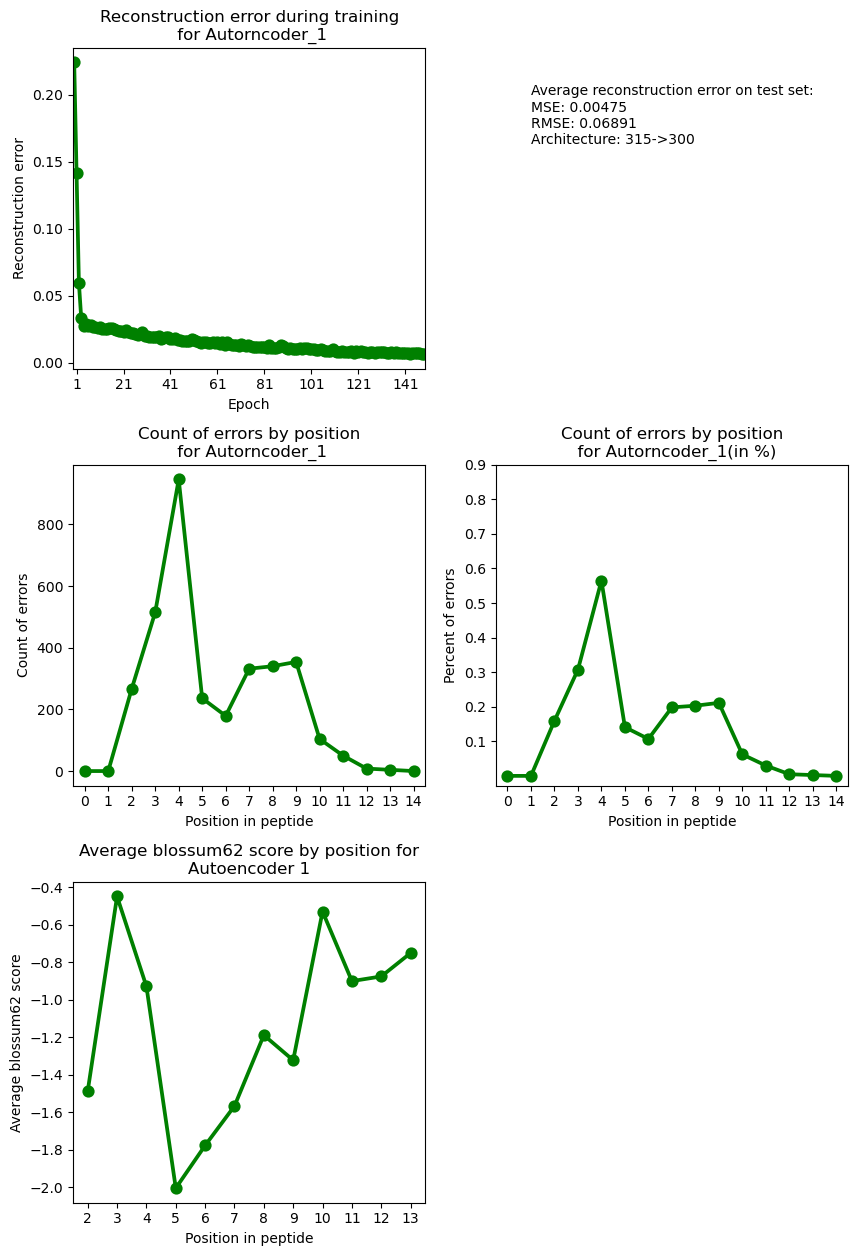

In [28]:
fig, axs = plt.subplots(3,2, figsize = [10, 15])
sns.pointplot(train_loss_avg_1, color = 'green', ax=axs[0, 0])
sns.pointplot(err_count, color = 'green', ax=axs[1, 0])
sns.pointplot(err_count/len(pep_test_list_bef_ae), color = 'green', ax=axs[1, 1])
axs[0, 0].set(xlabel='Epoch', ylabel='Reconstruction error', title = 'Reconstruction error during training\n for Autorncoder_1', xticks=[i for i in range(1, num_epochs, 20)])
axs[0, 1].set(frame_on=False)
axs[0, 1].set_xticks([])
axs[0, 1].set_yticks([])
axs[0, 1].text(x=0.1, y=0.7, s=f'Average reconstruction error on test set:\nMSE: {round(test_loss_avg_1, 5)}\nRMSE: {round(sqrt(test_loss_avg_1), 5)}\nArchitecture: {autoencoder_arch}')
axs[1, 0].set(xlabel='Position in peptide', ylabel='Count of errors', title='Count of errors by position\n for Autorncoder_1')
axs[1, 1].set(xlabel='Position in peptide', ylabel='Percent of errors', title='Count of errors by position\n  for Autorncoder_1(in %)', yticks=[i/10 for i in range(1, 10)])
sns.pointplot(x=avg_blos_score.keys(), y=avg_blos_score.values(), color='green', ax=axs[2,0])
axs[2, 0].set(xlabel='Position in peptide', ylabel='Average blossum62 score', title='Average blossum62 score by position for\nAutoencoder 1')
plt.subplots_adjust(wspace=0.2, hspace=0.3)
axs[2, 1].set(frame_on=False)
axs[2, 1].set_xticks([])
axs[2, 1].set_yticks([])
plt.show()
fig.savefig(f'./Results_one_hot/{numb}_{str(date.today())}_test_{autoencoder_arch}.pdf', format='pdf')


## Autoencoder_5 definition (315->700->200)

In [29]:
numb += 1
autoencoder_arch = '315->700->200'

class Encoder(nn.Module):
    def __init__(self):
        super(Encoder, self).__init__()
        self.fc1 = nn.Linear(in_features=len(AA_LIST)*len_seq, out_features=700)
        self.fc2 = nn.Linear(in_features=700, out_features=200)
            
    def forward(self, x):
        x = self.fc1(x)
        x = F.relu(x)
        x = self.fc2(x)
        return x

class Decoder(nn.Module):
    def __init__(self):
        super(Decoder, self).__init__()
        self.fc1 = nn.Linear(in_features=200, out_features=700)
        self.fc2 = nn.Linear(in_features=700, out_features=len(AA_LIST)*len_seq)
            
    def forward(self, x):
        x = self.fc1(x)
        x = F.relu(x)
        x = self.fc2(x)
        x = F.sigmoid(x)
        return x
    
class Autoencoder(nn.Module):
    def __init__(self):
        super(Autoencoder, self).__init__()
        self.encoder = Encoder()
        self.decoder = Decoder()
    
    def forward(self, x):
        latent = self.encoder(x)
        x_recon = self.decoder(latent)
        return x_recon
    
autoencoder_1 = Autoencoder()

autoencoder_1 = autoencoder_1.to(device)

num_params = sum(p.numel() for p in autoencoder_1.parameters() if p.requires_grad)
print('Number of parameters for One-hot encoding: %d' % num_params)

loss_function = nn.MSELoss()

optimizer = torch.optim.Adam(autoencoder_1.parameters(), lr = learning_rate, weight_decay = 1e-5)

Number of parameters for One-hot encoding: 701900


### Train autoencoder

In [30]:
# set to training mode
autoencoder_1.train()

train_loss_avg_1 = []

print('Training ...')
for epoch in range(num_epochs):
    train_loss_avg_1.append(0)
    num_batches = 0
    
    for pep_batch, _ in oh_dl_train:
        
        pep_batch = pep_batch.to(device)

        pep_batch = pep_batch.reshape(-1, oh_matr_size)
        
        # autoencoder reconstruction
        pep_batch_recon = autoencoder_1(pep_batch)
        
        # reconstruction error
        loss = loss_function(pep_batch_recon, pep_batch)
        
        # backpropagation
        optimizer.zero_grad()
        loss.backward()
        
        # one step of the optmizer (using the gradients from backpropagation)
        optimizer.step()
        
        train_loss_avg_1[-1] += loss.item()
        num_batches += 1
        
    train_loss_avg_1[-1] /= num_batches
    if epoch % 10 == 0:
        print('Epoch [%d / %d] average reconstruction error: %f' % (epoch+1, num_epochs, train_loss_avg_1[-1]))
print('Train finished')

Training ...
Epoch [1 / 150] average reconstruction error: 0.195850
Epoch [11 / 150] average reconstruction error: 0.032520
Epoch [21 / 150] average reconstruction error: 0.027044
Epoch [31 / 150] average reconstruction error: 0.020472
Epoch [41 / 150] average reconstruction error: 0.017758
Epoch [51 / 150] average reconstruction error: 0.016569
Epoch [61 / 150] average reconstruction error: 0.014864
Epoch [71 / 150] average reconstruction error: 0.013212
Epoch [81 / 150] average reconstruction error: 0.012833
Epoch [91 / 150] average reconstruction error: 0.012876
Epoch [101 / 150] average reconstruction error: 0.012448
Epoch [111 / 150] average reconstruction error: 0.012609
Epoch [121 / 150] average reconstruction error: 0.012226
Epoch [131 / 150] average reconstruction error: 0.012874
Epoch [141 / 150] average reconstruction error: 0.011574
Train finished


### Evaluation

In [31]:
autoencoder_1.eval()

output = []
test_loss_avg_1, num_batches = 0, 0

# Прогоняем тестовую выборку через автоэнкодер
for (pep, _) in oh_dl_test:
    with torch.no_grad():
        pep = pep.reshape(-1, oh_matr_size)
        pep = pep.to(device)
        pep_recon = autoencoder_1(pep)
        loss = loss_function(pep_recon, pep)
        test_loss_avg_1 += loss.item()
        num_batches += 1
    output.append((pep, pep_recon))
test_loss_avg_1 /= num_batches


test_loss_avg_1 /= num_batches
print('Average reconstruction error: %f' % (test_loss_avg_1))

# Output выглядит странно это лист, состоящий из кортежей, каждый из которых относится к одному батчу. Т.е. ouput[0] - это кортеж из первого батча
# Далее каждый кортеж, состоит из двух тензоров: до и после энкодера. Тензоры в 2д формате.


# Создаём пустые(нулевые) массивы для one-hot петпидов до и после
pep_test_oh_bef = np.zeros((len(pep_test_list), len(pepcode.AA_LIST), len_seq), dtype = np.float32)
pep_test_oh_aft = np.zeros((len(pep_test_list), len(pepcode.AA_LIST), len_seq), dtype = np.float32)


# Переводим пептиды в np массив из output
pointer = 0
for i in range(num_batches):
    cur_batch_size = len(output[i][0])
    pep_test_oh_bef[pointer:pointer + cur_batch_size, :, : ] = output[i][0].reshape((cur_batch_size, len(AA_LIST), len_seq)).numpy(force=True)
    pep_test_oh_aft[pointer:pointer + cur_batch_size, :, : ] = output[i][1].reshape((cur_batch_size, len(AA_LIST), len_seq)).numpy(force=True)
    pointer += cur_batch_size
    

# Для каждого пептида после автоэнкодера приводим его к формату one-hot путем простанови 1 на место максимального веса в столбце
for i in range(pep_test_oh_aft.shape[0]):
    for j in range(len_seq):
        col_max = np.max(pep_test_oh_aft[i][:,j])
        for k in range(len(AA_LIST)):
            if pep_test_oh_aft[i][k][j] == col_max:
                pep_test_oh_aft[i][k][j] = 1.0
            else: 
                pep_test_oh_aft[i][k][j] = 0.0  

pep_test_list_bef_ae = []
pep_test_list_aft_ae = []

for i in range(pep_test_oh_aft.shape[0]):
    pep_test_list_bef_ae.append(pepcode.one_hot_decode(pep_test_oh_bef[i]))   
    pep_test_list_aft_ae.append(pepcode.one_hot_decode(pep_test_oh_aft[i]))

Average reconstruction error: 0.006907


### Biological evaluatiuon

In [32]:
err_count = np.zeros(len_seq, dtype = np.float32)
blos_score = np.zeros(len_seq, dtype = np.float32)

for i in range(len(pep_test_list_bef_ae)):
    for j in range(len_seq):
        if pep_test_list_bef_ae[i][j] != pep_test_list_aft_ae[i][j]:
            err_count[j] +=1
            blos_score[j] += pepcode.blosum_score(pep_test_list_bef_ae[i][j],pep_test_list_aft_ae[i][j])


avg_blos_score = {}
for i in range(len_seq):
    if err_count[i] !=0:
        avg_blos_score[i]=blos_score[i]/err_count[i]

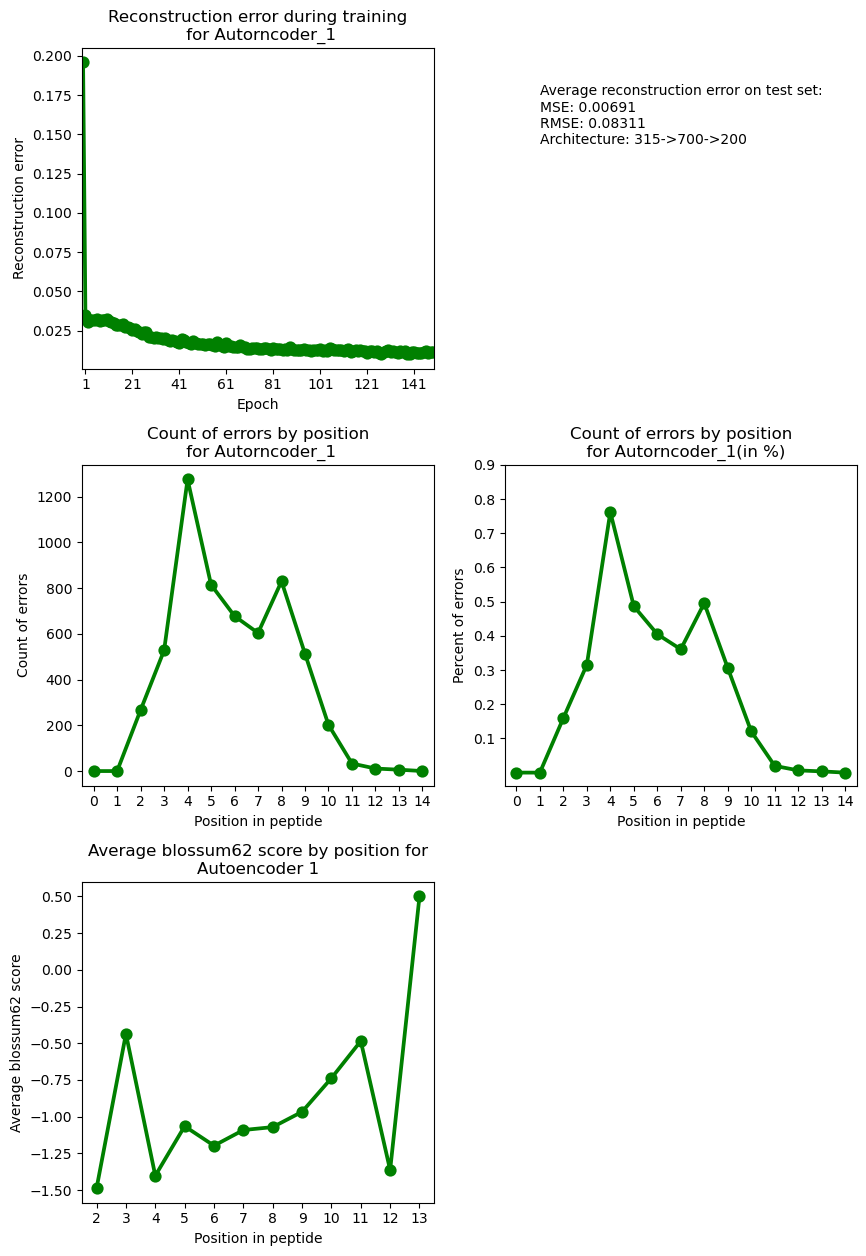

In [33]:
fig, axs = plt.subplots(3,2, figsize = [10, 15])
sns.pointplot(train_loss_avg_1, color = 'green', ax=axs[0, 0])
sns.pointplot(err_count, color = 'green', ax=axs[1, 0])
sns.pointplot(err_count/len(pep_test_list_bef_ae), color = 'green', ax=axs[1, 1])
axs[0, 0].set(xlabel='Epoch', ylabel='Reconstruction error', title = 'Reconstruction error during training\n for Autorncoder_1', xticks=[i for i in range(1, num_epochs, 20)])
axs[0, 1].set(frame_on=False)
axs[0, 1].set_xticks([])
axs[0, 1].set_yticks([])
axs[0, 1].text(x=0.1, y=0.7, s=f'Average reconstruction error on test set:\nMSE: {round(test_loss_avg_1, 5)}\nRMSE: {round(sqrt(test_loss_avg_1), 5)}\nArchitecture: {autoencoder_arch}')
axs[1, 0].set(xlabel='Position in peptide', ylabel='Count of errors', title='Count of errors by position\n for Autorncoder_1')
axs[1, 1].set(xlabel='Position in peptide', ylabel='Percent of errors', title='Count of errors by position\n  for Autorncoder_1(in %)', yticks=[i/10 for i in range(1, 10)])
sns.pointplot(x=avg_blos_score.keys(), y=avg_blos_score.values(), color='green', ax=axs[2,0])
axs[2, 0].set(xlabel='Position in peptide', ylabel='Average blossum62 score', title='Average blossum62 score by position for\nAutoencoder 1')
plt.subplots_adjust(wspace=0.2, hspace=0.3)
axs[2, 1].set(frame_on=False)
axs[2, 1].set_xticks([])
axs[2, 1].set_yticks([])
plt.show()
fig.savefig(f'./Results_one_hot/{numb}_{str(date.today())}_test_{autoencoder_arch}.pdf', format='pdf')


## Autoencoder_6 definition (315->200->100)

In [34]:
numb += 1
autoencoder_arch = '315->200->100'

class Encoder(nn.Module):
    def __init__(self):
        super(Encoder, self).__init__()
        self.fc1 = nn.Linear(in_features=len(AA_LIST)*len_seq, out_features=200)
        self.fc2 = nn.Linear(in_features=200, out_features=100)
            
    def forward(self, x):
        x = self.fc1(x)
        x = F.relu(x)
        x = self.fc2(x)
        return x

class Decoder(nn.Module):
    def __init__(self):
        super(Decoder, self).__init__()
        self.fc1 = nn.Linear(in_features=100, out_features=200)
        self.fc2 = nn.Linear(in_features=200, out_features=len(AA_LIST)*len_seq)
            
    def forward(self, x):
        x = self.fc1(x)
        x = F.relu(x)
        x = self.fc2(x)
        x = F.sigmoid(x)
        return x
    
class Autoencoder(nn.Module):
    def __init__(self):
        super(Autoencoder, self).__init__()
        self.encoder = Encoder()
        self.decoder = Decoder()
    
    def forward(self, x):
        latent = self.encoder(x)
        x_recon = self.decoder(latent)
        return x_recon
    
autoencoder_1 = Autoencoder()

autoencoder_1 = autoencoder_1.to(device)

num_params = sum(p.numel() for p in autoencoder_1.parameters() if p.requires_grad)
print('Number of parameters for One-hot encoding: %d' % num_params)

loss_function = nn.MSELoss()

optimizer = torch.optim.Adam(autoencoder_1.parameters(), lr = learning_rate, weight_decay = 1e-5)

Number of parameters for One-hot encoding: 160800


### Train autoencoder

In [35]:
# set to training mode
autoencoder_1.train()

train_loss_avg_1 = []

print('Training ...')
for epoch in range(num_epochs):
    train_loss_avg_1.append(0)
    num_batches = 0
    
    for pep_batch, _ in oh_dl_train:
        
        pep_batch = pep_batch.to(device)

        pep_batch = pep_batch.reshape(-1, oh_matr_size)
        
        # autoencoder reconstruction
        pep_batch_recon = autoencoder_1(pep_batch)
        
        # reconstruction error
        loss = loss_function(pep_batch_recon, pep_batch)
        
        # backpropagation
        optimizer.zero_grad()
        loss.backward()
        
        # one step of the optmizer (using the gradients from backpropagation)
        optimizer.step()
        
        train_loss_avg_1[-1] += loss.item()
        num_batches += 1
        
    train_loss_avg_1[-1] /= num_batches
    if epoch % 10 == 0:
        print('Epoch [%d / %d] average reconstruction error: %f' % (epoch+1, num_epochs, train_loss_avg_1[-1]))
print('Train finished')

Training ...
Epoch [1 / 150] average reconstruction error: 0.240500
Epoch [11 / 150] average reconstruction error: 0.028933
Epoch [21 / 150] average reconstruction error: 0.027618
Epoch [31 / 150] average reconstruction error: 0.025679
Epoch [41 / 150] average reconstruction error: 0.022261
Epoch [51 / 150] average reconstruction error: 0.018993
Epoch [61 / 150] average reconstruction error: 0.019450
Epoch [71 / 150] average reconstruction error: 0.018784
Epoch [81 / 150] average reconstruction error: 0.016974
Epoch [91 / 150] average reconstruction error: 0.016188
Epoch [101 / 150] average reconstruction error: 0.016474
Epoch [111 / 150] average reconstruction error: 0.016894
Epoch [121 / 150] average reconstruction error: 0.014390
Epoch [131 / 150] average reconstruction error: 0.015155
Epoch [141 / 150] average reconstruction error: 0.014160
Train finished


### Evaluation

In [36]:
autoencoder_1.eval()

output = []
test_loss_avg_1, num_batches = 0, 0

# Прогоняем тестовую выборку через автоэнкодер
for (pep, _) in oh_dl_test:
    with torch.no_grad():
        pep = pep.reshape(-1, oh_matr_size)
        pep = pep.to(device)
        pep_recon = autoencoder_1(pep)
        loss = loss_function(pep_recon, pep)
        test_loss_avg_1 += loss.item()
        num_batches += 1
    output.append((pep, pep_recon))
test_loss_avg_1 /= num_batches


test_loss_avg_1 /= num_batches
print('Average reconstruction error: %f' % (test_loss_avg_1))

# Output выглядит странно это лист, состоящий из кортежей, каждый из которых относится к одному батчу. Т.е. ouput[0] - это кортеж из первого батча
# Далее каждый кортеж, состоит из двух тензоров: до и после энкодера. Тензоры в 2д формате.


# Создаём пустые(нулевые) массивы для one-hot петпидов до и после
pep_test_oh_bef = np.zeros((len(pep_test_list), len(pepcode.AA_LIST), len_seq), dtype = np.float32)
pep_test_oh_aft = np.zeros((len(pep_test_list), len(pepcode.AA_LIST), len_seq), dtype = np.float32)


# Переводим пептиды в np массив из output
pointer = 0
for i in range(num_batches):
    cur_batch_size = len(output[i][0])
    pep_test_oh_bef[pointer:pointer + cur_batch_size, :, : ] = output[i][0].reshape((cur_batch_size, len(AA_LIST), len_seq)).numpy(force=True)
    pep_test_oh_aft[pointer:pointer + cur_batch_size, :, : ] = output[i][1].reshape((cur_batch_size, len(AA_LIST), len_seq)).numpy(force=True)
    pointer += cur_batch_size
    

# Для каждого пептида после автоэнкодера приводим его к формату one-hot путем простанови 1 на место максимального веса в столбце
for i in range(pep_test_oh_aft.shape[0]):
    for j in range(len_seq):
        col_max = np.max(pep_test_oh_aft[i][:,j])
        for k in range(len(AA_LIST)):
            if pep_test_oh_aft[i][k][j] == col_max:
                pep_test_oh_aft[i][k][j] = 1.0
            else: 
                pep_test_oh_aft[i][k][j] = 0.0  

pep_test_list_bef_ae = []
pep_test_list_aft_ae = []

for i in range(pep_test_oh_aft.shape[0]):
    pep_test_list_bef_ae.append(pepcode.one_hot_decode(pep_test_oh_bef[i]))   
    pep_test_list_aft_ae.append(pepcode.one_hot_decode(pep_test_oh_aft[i]))

Average reconstruction error: 0.008690


### Biological evaluatiuon

In [37]:
err_count = np.zeros(len_seq, dtype = np.float32)
blos_score = np.zeros(len_seq, dtype = np.float32)

for i in range(len(pep_test_list_bef_ae)):
    for j in range(len_seq):
        if pep_test_list_bef_ae[i][j] != pep_test_list_aft_ae[i][j]:
            err_count[j] +=1
            blos_score[j] += pepcode.blosum_score(pep_test_list_bef_ae[i][j],pep_test_list_aft_ae[i][j])


avg_blos_score = {}
for i in range(len_seq):
    if err_count[i] !=0:
        avg_blos_score[i]=blos_score[i]/err_count[i]

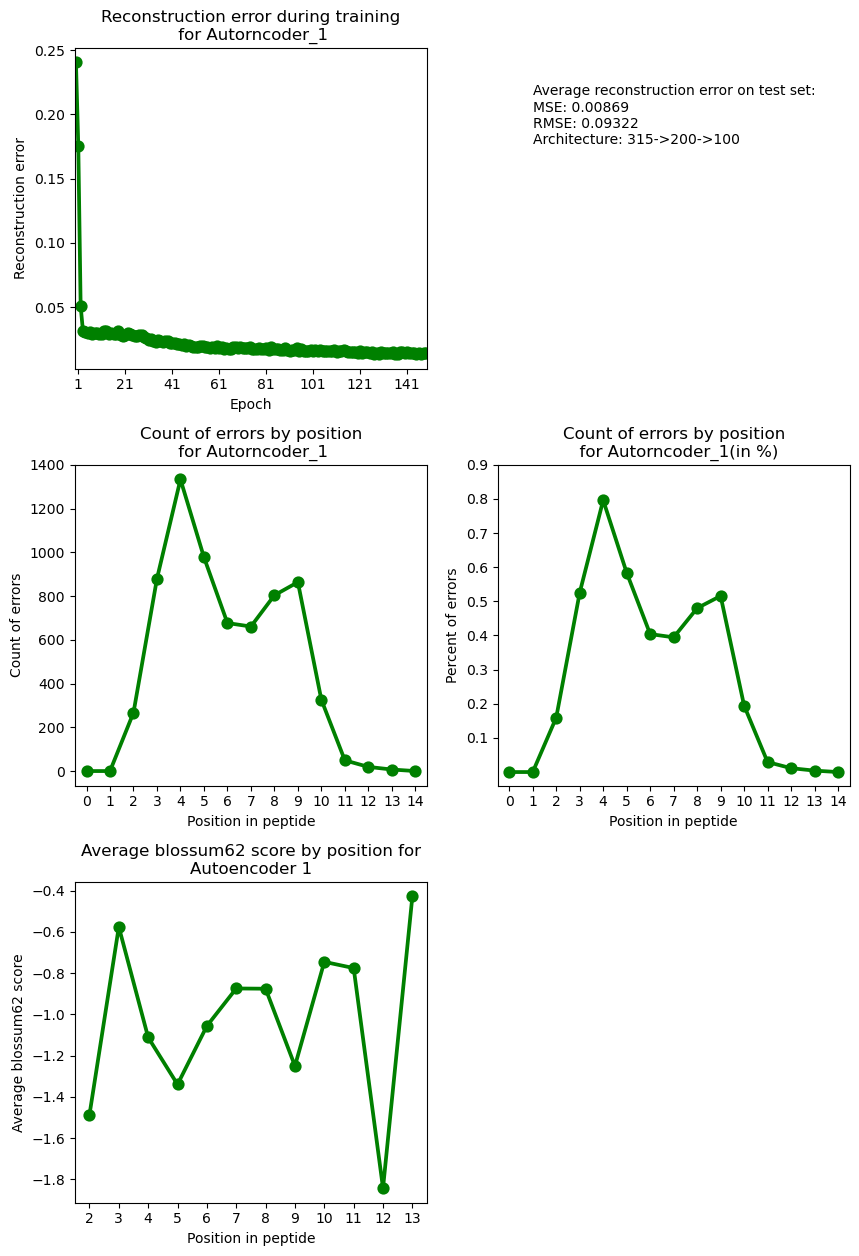

In [38]:
fig, axs = plt.subplots(3,2, figsize = [10, 15])
sns.pointplot(train_loss_avg_1, color = 'green', ax=axs[0, 0])
sns.pointplot(err_count, color = 'green', ax=axs[1, 0])
sns.pointplot(err_count/len(pep_test_list_bef_ae), color = 'green', ax=axs[1, 1])
axs[0, 0].set(xlabel='Epoch', ylabel='Reconstruction error', title = 'Reconstruction error during training\n for Autorncoder_1', xticks=[i for i in range(1, num_epochs, 20)])
axs[0, 1].set(frame_on=False)
axs[0, 1].set_xticks([])
axs[0, 1].set_yticks([])
axs[0, 1].text(x=0.1, y=0.7, s=f'Average reconstruction error on test set:\nMSE: {round(test_loss_avg_1, 5)}\nRMSE: {round(sqrt(test_loss_avg_1), 5)}\nArchitecture: {autoencoder_arch}')
axs[1, 0].set(xlabel='Position in peptide', ylabel='Count of errors', title='Count of errors by position\n for Autorncoder_1')
axs[1, 1].set(xlabel='Position in peptide', ylabel='Percent of errors', title='Count of errors by position\n  for Autorncoder_1(in %)', yticks=[i/10 for i in range(1, 10)])
sns.pointplot(x=avg_blos_score.keys(), y=avg_blos_score.values(), color='green', ax=axs[2,0])
axs[2, 0].set(xlabel='Position in peptide', ylabel='Average blossum62 score', title='Average blossum62 score by position for\nAutoencoder 1')
plt.subplots_adjust(wspace=0.2, hspace=0.3)
axs[2, 1].set(frame_on=False)
axs[2, 1].set_xticks([])
axs[2, 1].set_yticks([])
plt.show()
fig.savefig(f'./Results_one_hot/{numb}_{str(date.today())}_test_{autoencoder_arch}.pdf', format='pdf')


## Autoencoder_7 definition (315->800->600->200)

In [39]:
numb += 1
autoencoder_arch = '315->800->600->200'

class Encoder(nn.Module):
    def __init__(self):
        super(Encoder, self).__init__()
        self.fc1 = nn.Linear(in_features=len(AA_LIST)*len_seq, out_features=800)
        self.fc2 = nn.Linear(in_features=800, out_features=600)
        self.fc3 = nn.Linear(in_features=600, out_features=200)
            
    def forward(self, x):
        x = self.fc1(x)
        x = F.relu(x)
        x = self.fc2(x)
        x = F.relu(x)
        x = self.fc3(x)
        return x

class Decoder(nn.Module):
    def __init__(self):
        super(Decoder, self).__init__()
        self.fc1 = nn.Linear(in_features=200, out_features=600)
        self.fc2 = nn.Linear(in_features=600, out_features=800)
        self.fc3 = nn.Linear(in_features=800, out_features=len(AA_LIST)*len_seq)
            
    def forward(self, x):
        x = self.fc1(x)
        x = F.relu(x)
        x = self.fc2(x)
        x = F.relu(x)
        x = self.fc3(x)
        x = F.sigmoid(x)
        return x
    
class Autoencoder(nn.Module):
    def __init__(self):
        super(Autoencoder, self).__init__()
        self.encoder = Encoder()
        self.decoder = Decoder()
    
    def forward(self, x):
        latent = self.encoder(x)
        x_recon = self.decoder(latent)
        return x_recon
    
autoencoder_1 = Autoencoder()

autoencoder_1 = autoencoder_1.to(device)

num_params = sum(p.numel() for p in autoencoder_1.parameters() if p.requires_grad)
print('Number of parameters for One-hot encoding: %d' % num_params)

loss_function = nn.MSELoss()

optimizer = torch.optim.Adam(autoencoder_1.parameters(), lr = learning_rate, weight_decay = 1e-5)

Number of parameters for One-hot encoding: 1683300


### Train autoencoder

In [40]:
# set to training mode
autoencoder_1.train()

train_loss_avg_1 = []

print('Training ...')
for epoch in range(num_epochs):
    train_loss_avg_1.append(0)
    num_batches = 0
    
    for pep_batch, _ in oh_dl_train:
        
        pep_batch = pep_batch.to(device)

        pep_batch = pep_batch.reshape(-1, oh_matr_size)
        
        # autoencoder reconstruction
        pep_batch_recon = autoencoder_1(pep_batch)
        
        # reconstruction error
        loss = loss_function(pep_batch_recon, pep_batch)
        
        # backpropagation
        optimizer.zero_grad()
        loss.backward()
        
        # one step of the optmizer (using the gradients from backpropagation)
        optimizer.step()
        
        train_loss_avg_1[-1] += loss.item()
        num_batches += 1
        
    train_loss_avg_1[-1] /= num_batches
    if epoch % 10 == 0:
        print('Epoch [%d / %d] average reconstruction error: %f' % (epoch+1, num_epochs, train_loss_avg_1[-1]))
print('Train finished')

Training ...
Epoch [1 / 150] average reconstruction error: 0.183989
Epoch [11 / 150] average reconstruction error: 0.035935
Epoch [21 / 150] average reconstruction error: 0.036226
Epoch [31 / 150] average reconstruction error: 0.037177
Epoch [41 / 150] average reconstruction error: 0.037177
Epoch [51 / 150] average reconstruction error: 0.036226
Epoch [61 / 150] average reconstruction error: 0.036672
Epoch [71 / 150] average reconstruction error: 0.037104
Epoch [81 / 150] average reconstruction error: 0.036664
Epoch [91 / 150] average reconstruction error: 0.037560
Epoch [101 / 150] average reconstruction error: 0.028116
Epoch [111 / 150] average reconstruction error: 0.028112
Epoch [121 / 150] average reconstruction error: 0.024037
Epoch [131 / 150] average reconstruction error: 0.022826
Epoch [141 / 150] average reconstruction error: 0.021305
Train finished


### Evaluation

In [41]:
autoencoder_1.eval()

output = []
test_loss_avg_1, num_batches = 0, 0

# Прогоняем тестовую выборку через автоэнкодер
for (pep, _) in oh_dl_test:
    with torch.no_grad():
        pep = pep.reshape(-1, oh_matr_size)
        pep = pep.to(device)
        pep_recon = autoencoder_1(pep)
        loss = loss_function(pep_recon, pep)
        test_loss_avg_1 += loss.item()
        num_batches += 1
    output.append((pep, pep_recon))
test_loss_avg_1 /= num_batches


test_loss_avg_1 /= num_batches
print('Average reconstruction error: %f' % (test_loss_avg_1))

# Output выглядит странно это лист, состоящий из кортежей, каждый из которых относится к одному батчу. Т.е. ouput[0] - это кортеж из первого батча
# Далее каждый кортеж, состоит из двух тензоров: до и после энкодера. Тензоры в 2д формате.


# Создаём пустые(нулевые) массивы для one-hot петпидов до и после
pep_test_oh_bef = np.zeros((len(pep_test_list), len(pepcode.AA_LIST), len_seq), dtype = np.float32)
pep_test_oh_aft = np.zeros((len(pep_test_list), len(pepcode.AA_LIST), len_seq), dtype = np.float32)


# Переводим пептиды в np массив из output
pointer = 0
for i in range(num_batches):
    cur_batch_size = len(output[i][0])
    pep_test_oh_bef[pointer:pointer + cur_batch_size, :, : ] = output[i][0].reshape((cur_batch_size, len(AA_LIST), len_seq)).numpy(force=True)
    pep_test_oh_aft[pointer:pointer + cur_batch_size, :, : ] = output[i][1].reshape((cur_batch_size, len(AA_LIST), len_seq)).numpy(force=True)
    pointer += cur_batch_size
    

# Для каждого пептида после автоэнкодера приводим его к формату one-hot путем простанови 1 на место максимального веса в столбце
for i in range(pep_test_oh_aft.shape[0]):
    for j in range(len_seq):
        col_max = np.max(pep_test_oh_aft[i][:,j])
        for k in range(len(AA_LIST)):
            if pep_test_oh_aft[i][k][j] == col_max:
                pep_test_oh_aft[i][k][j] = 1.0
            else: 
                pep_test_oh_aft[i][k][j] = 0.0  

pep_test_list_bef_ae = []
pep_test_list_aft_ae = []

for i in range(pep_test_oh_aft.shape[0]):
    pep_test_list_bef_ae.append(pepcode.one_hot_decode(pep_test_oh_bef[i]))   
    pep_test_list_aft_ae.append(pepcode.one_hot_decode(pep_test_oh_aft[i]))

Average reconstruction error: 0.011906


### Biological evaluatiuon

In [42]:
err_count = np.zeros(len_seq, dtype = np.float32)
blos_score = np.zeros(len_seq, dtype = np.float32)

for i in range(len(pep_test_list_bef_ae)):
    for j in range(len_seq):
        if pep_test_list_bef_ae[i][j] != pep_test_list_aft_ae[i][j]:
            err_count[j] +=1
            blos_score[j] += pepcode.blosum_score(pep_test_list_bef_ae[i][j],pep_test_list_aft_ae[i][j])


avg_blos_score = {}
for i in range(len_seq):
    if err_count[i] !=0:
        avg_blos_score[i]=blos_score[i]/err_count[i]

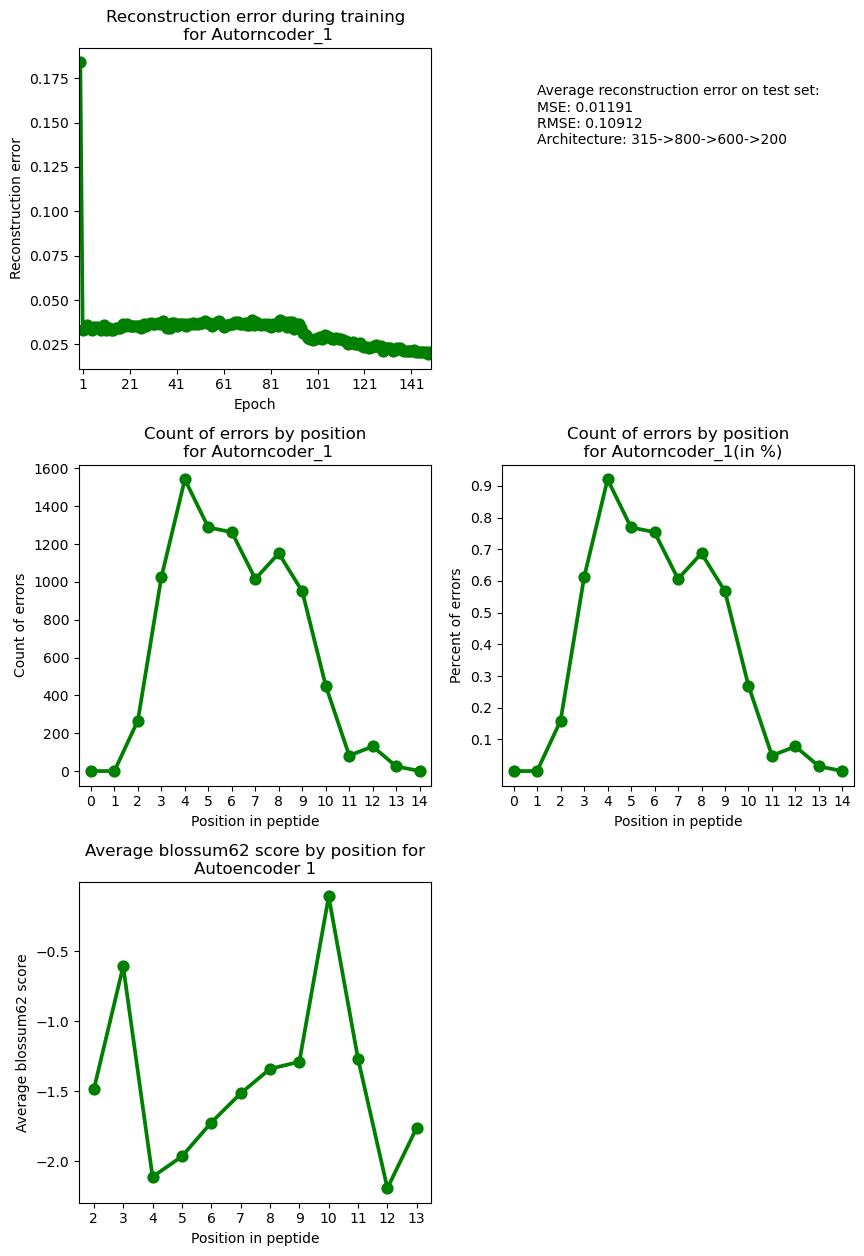

In [43]:
fig, axs = plt.subplots(3,2, figsize = [10, 15])
sns.pointplot(train_loss_avg_1, color = 'green', ax=axs[0, 0])
sns.pointplot(err_count, color = 'green', ax=axs[1, 0])
sns.pointplot(err_count/len(pep_test_list_bef_ae), color = 'green', ax=axs[1, 1])
axs[0, 0].set(xlabel='Epoch', ylabel='Reconstruction error', title = 'Reconstruction error during training\n for Autorncoder_1', xticks=[i for i in range(1, num_epochs, 20)])
axs[0, 1].set(frame_on=False)
axs[0, 1].set_xticks([])
axs[0, 1].set_yticks([])
axs[0, 1].text(x=0.1, y=0.7, s=f'Average reconstruction error on test set:\nMSE: {round(test_loss_avg_1, 5)}\nRMSE: {round(sqrt(test_loss_avg_1), 5)}\nArchitecture: {autoencoder_arch}')
axs[1, 0].set(xlabel='Position in peptide', ylabel='Count of errors', title='Count of errors by position\n for Autorncoder_1')
axs[1, 1].set(xlabel='Position in peptide', ylabel='Percent of errors', title='Count of errors by position\n  for Autorncoder_1(in %)', yticks=[i/10 for i in range(1, 10)])
sns.pointplot(x=avg_blos_score.keys(), y=avg_blos_score.values(), color='green', ax=axs[2,0])
axs[2, 0].set(xlabel='Position in peptide', ylabel='Average blossum62 score', title='Average blossum62 score by position for\nAutoencoder 1')
plt.subplots_adjust(wspace=0.2, hspace=0.3)
axs[2, 1].set(frame_on=False)
axs[2, 1].set_xticks([])
axs[2, 1].set_yticks([])
plt.show()
fig.savefig(f'./Results_one_hot/{numb}_{str(date.today())}_test_{autoencoder_arch}.pdf', format='pdf')


## Autoencoder_8 definition (315->500D->100)

In [44]:
numb += 1
autoencoder_arch = '315->500D->100'

class Encoder(nn.Module):
    def __init__(self):
        super(Encoder, self).__init__()
        self.fc1 = nn.Linear(in_features=len(AA_LIST)*len_seq, out_features=500)
        self.fc2 = nn.Linear(in_features=500, out_features=100)
            
    def forward(self, x):
        x = self.fc1(x)
        x = F.dropout(x, p=0.2)
        x = F.relu(x)
        x = self.fc2(x)
        return x

class Decoder(nn.Module):
    def __init__(self):
        super(Decoder, self).__init__()
        self.fc1 = nn.Linear(in_features=100, out_features=500)
        self.fc2 = nn.Linear(in_features=500, out_features=len(AA_LIST)*len_seq)
            
    def forward(self, x):
        x = self.fc1(x)
        x = F.relu(x)
        x = self.fc2(x)
        x = F.sigmoid(x)
        return x
    
class Autoencoder(nn.Module):
    def __init__(self):
        super(Autoencoder, self).__init__()
        self.encoder = Encoder()
        self.decoder = Decoder()
    
    def forward(self, x):
        latent = self.encoder(x)
        x_recon = self.decoder(latent)
        return x_recon
    
autoencoder_1 = Autoencoder()

autoencoder_1 = autoencoder_1.to(device)

num_params = sum(p.numel() for p in autoencoder_1.parameters() if p.requires_grad)
print('Number of parameters for One-hot encoding: %d' % num_params)

loss_function = nn.MSELoss()

optimizer = torch.optim.Adam(autoencoder_1.parameters(), lr = learning_rate, weight_decay = 1e-5)

Number of parameters for One-hot encoding: 401400


### Train autoencoder

In [45]:
# set to training mode
autoencoder_1.train()

train_loss_avg_1 = []

print('Training ...')
for epoch in range(num_epochs):
    train_loss_avg_1.append(0)
    num_batches = 0
    
    for pep_batch, _ in oh_dl_train:
        
        pep_batch = pep_batch.to(device)

        pep_batch = pep_batch.reshape(-1, oh_matr_size)
        
        # autoencoder reconstruction
        pep_batch_recon = autoencoder_1(pep_batch)
        
        # reconstruction error
        loss = loss_function(pep_batch_recon, pep_batch)
        
        # backpropagation
        optimizer.zero_grad()
        loss.backward()
        
        # one step of the optmizer (using the gradients from backpropagation)
        optimizer.step()
        
        train_loss_avg_1[-1] += loss.item()
        num_batches += 1
        
    train_loss_avg_1[-1] /= num_batches
    if epoch % 10 == 0:
        print('Epoch [%d / %d] average reconstruction error: %f' % (epoch+1, num_epochs, train_loss_avg_1[-1]))
print('Train finished')

Training ...
Epoch [1 / 150] average reconstruction error: 0.223801
Epoch [11 / 150] average reconstruction error: 0.031309
Epoch [21 / 150] average reconstruction error: 0.027964
Epoch [31 / 150] average reconstruction error: 0.023932
Epoch [41 / 150] average reconstruction error: 0.019422
Epoch [51 / 150] average reconstruction error: 0.018653
Epoch [61 / 150] average reconstruction error: 0.017069
Epoch [71 / 150] average reconstruction error: 0.016135
Epoch [81 / 150] average reconstruction error: 0.014252
Epoch [91 / 150] average reconstruction error: 0.014806
Epoch [101 / 150] average reconstruction error: 0.013692
Epoch [111 / 150] average reconstruction error: 0.013657
Epoch [121 / 150] average reconstruction error: 0.014534
Epoch [131 / 150] average reconstruction error: 0.013849
Epoch [141 / 150] average reconstruction error: 0.013009
Train finished


### Evaluation

In [46]:
autoencoder_1.eval()

output = []
test_loss_avg_1, num_batches = 0, 0

# Прогоняем тестовую выборку через автоэнкодер
for (pep, _) in oh_dl_test:
    with torch.no_grad():
        pep = pep.reshape(-1, oh_matr_size)
        pep = pep.to(device)
        pep_recon = autoencoder_1(pep)
        loss = loss_function(pep_recon, pep)
        test_loss_avg_1 += loss.item()
        num_batches += 1
    output.append((pep, pep_recon))
test_loss_avg_1 /= num_batches


test_loss_avg_1 /= num_batches
print('Average reconstruction error: %f' % (test_loss_avg_1))

# Output выглядит странно это лист, состоящий из кортежей, каждый из которых относится к одному батчу. Т.е. ouput[0] - это кортеж из первого батча
# Далее каждый кортеж, состоит из двух тензоров: до и после энкодера. Тензоры в 2д формате.


# Создаём пустые(нулевые) массивы для one-hot петпидов до и после
pep_test_oh_bef = np.zeros((len(pep_test_list), len(pepcode.AA_LIST), len_seq), dtype = np.float32)
pep_test_oh_aft = np.zeros((len(pep_test_list), len(pepcode.AA_LIST), len_seq), dtype = np.float32)


# Переводим пептиды в np массив из output
pointer = 0
for i in range(num_batches):
    cur_batch_size = len(output[i][0])
    pep_test_oh_bef[pointer:pointer + cur_batch_size, :, : ] = output[i][0].reshape((cur_batch_size, len(AA_LIST), len_seq)).numpy(force=True)
    pep_test_oh_aft[pointer:pointer + cur_batch_size, :, : ] = output[i][1].reshape((cur_batch_size, len(AA_LIST), len_seq)).numpy(force=True)
    pointer += cur_batch_size
    

# Для каждого пептида после автоэнкодера приводим его к формату one-hot путем простанови 1 на место максимального веса в столбце
for i in range(pep_test_oh_aft.shape[0]):
    for j in range(len_seq):
        col_max = np.max(pep_test_oh_aft[i][:,j])
        for k in range(len(AA_LIST)):
            if pep_test_oh_aft[i][k][j] == col_max:
                pep_test_oh_aft[i][k][j] = 1.0
            else: 
                pep_test_oh_aft[i][k][j] = 0.0  

pep_test_list_bef_ae = []
pep_test_list_aft_ae = []

for i in range(pep_test_oh_aft.shape[0]):
    pep_test_list_bef_ae.append(pepcode.one_hot_decode(pep_test_oh_bef[i]))   
    pep_test_list_aft_ae.append(pepcode.one_hot_decode(pep_test_oh_aft[i]))

Average reconstruction error: 0.007982


### Biological evaluatiuon

In [47]:
err_count = np.zeros(len_seq, dtype = np.float32)
blos_score = np.zeros(len_seq, dtype = np.float32)

for i in range(len(pep_test_list_bef_ae)):
    for j in range(len_seq):
        if pep_test_list_bef_ae[i][j] != pep_test_list_aft_ae[i][j]:
            err_count[j] +=1
            blos_score[j] += pepcode.blosum_score(pep_test_list_bef_ae[i][j],pep_test_list_aft_ae[i][j])


avg_blos_score = {}
for i in range(len_seq):
    if err_count[i] !=0:
        avg_blos_score[i]=blos_score[i]/err_count[i]

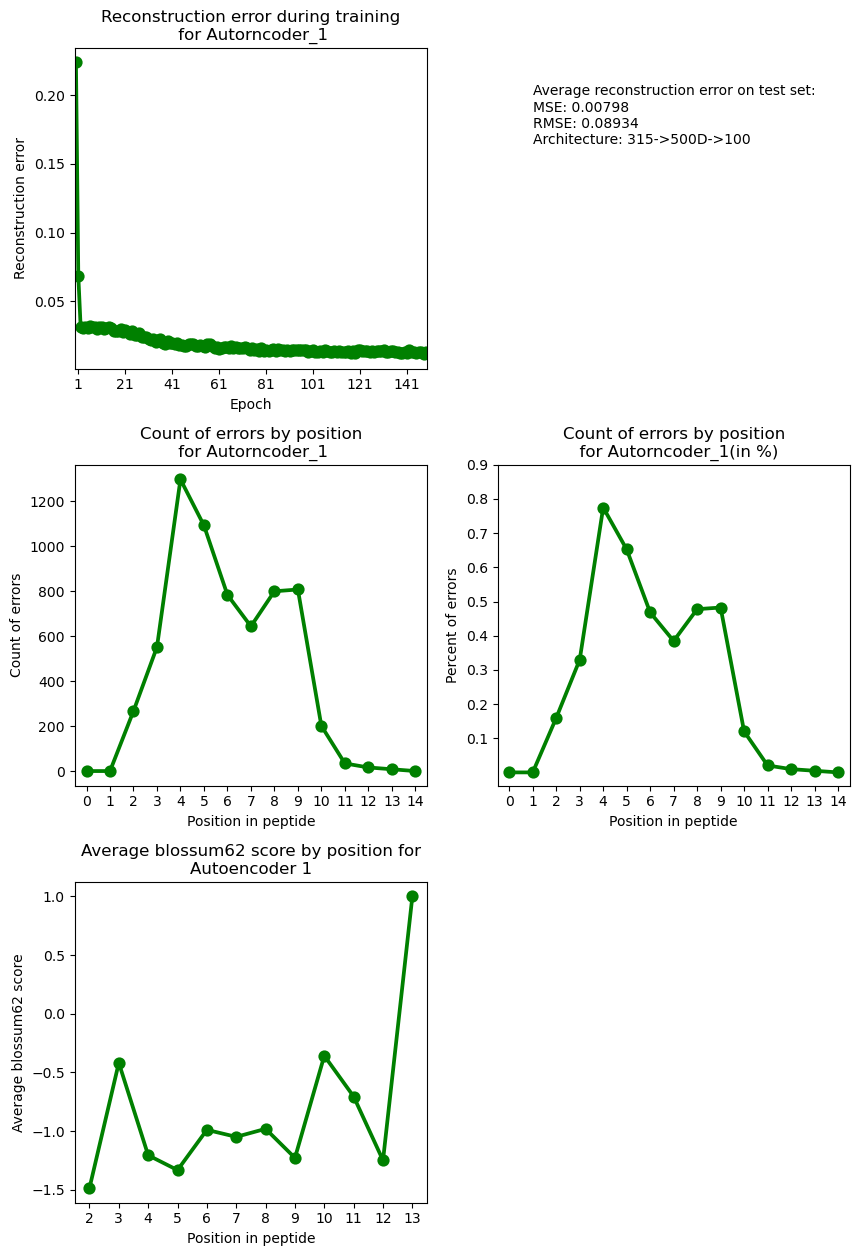

In [48]:
fig, axs = plt.subplots(3,2, figsize = [10, 15])
sns.pointplot(train_loss_avg_1, color = 'green', ax=axs[0, 0])
sns.pointplot(err_count, color = 'green', ax=axs[1, 0])
sns.pointplot(err_count/len(pep_test_list_bef_ae), color = 'green', ax=axs[1, 1])
axs[0, 0].set(xlabel='Epoch', ylabel='Reconstruction error', title = 'Reconstruction error during training\n for Autorncoder_1', xticks=[i for i in range(1, num_epochs, 20)])
axs[0, 1].set(frame_on=False)
axs[0, 1].set_xticks([])
axs[0, 1].set_yticks([])
axs[0, 1].text(x=0.1, y=0.7, s=f'Average reconstruction error on test set:\nMSE: {round(test_loss_avg_1, 5)}\nRMSE: {round(sqrt(test_loss_avg_1), 5)}\nArchitecture: {autoencoder_arch}')
axs[1, 0].set(xlabel='Position in peptide', ylabel='Count of errors', title='Count of errors by position\n for Autorncoder_1')
axs[1, 1].set(xlabel='Position in peptide', ylabel='Percent of errors', title='Count of errors by position\n  for Autorncoder_1(in %)', yticks=[i/10 for i in range(1, 10)])
sns.pointplot(x=avg_blos_score.keys(), y=avg_blos_score.values(), color='green', ax=axs[2,0])
axs[2, 0].set(xlabel='Position in peptide', ylabel='Average blossum62 score', title='Average blossum62 score by position for\nAutoencoder 1')
plt.subplots_adjust(wspace=0.2, hspace=0.3)
axs[2, 1].set(frame_on=False)
axs[2, 1].set_xticks([])
axs[2, 1].set_yticks([])
plt.show()
fig.savefig(f'./Results_one_hot/{numb}_{str(date.today())}_test_{autoencoder_arch}.pdf', format='pdf')


## Autoencoder_9 definition (315->2000->1000->200)

In [49]:
numb += 1
autoencoder_arch = '315->2000->1000->200'

class Encoder(nn.Module):
    def __init__(self):
        super(Encoder, self).__init__()
        self.fc1 = nn.Linear(in_features=len(AA_LIST)*len_seq, out_features=2000)
        self.fc2 = nn.Linear(in_features=2000, out_features=1000)
        self.fc3 = nn.Linear(in_features=1000, out_features=200)
            
    def forward(self, x):
        x = self.fc1(x)
        x = F.relu(x)
        x = self.fc2(x)
        x = F.relu(x)
        x = self.fc3(x)
        return x

class Decoder(nn.Module):
    def __init__(self):
        super(Decoder, self).__init__()
        self.fc1 = nn.Linear(in_features=200, out_features=1000)
        self.fc2 = nn.Linear(in_features=1000, out_features=2000)
        self.fc3 = nn.Linear(in_features=2000, out_features=len(AA_LIST)*len_seq)
            
    def forward(self, x):
        x = self.fc1(x)
        x = F.relu(x)
        x = self.fc2(x)
        x = F.relu(x)
        x = self.fc3(x)
        x = F.sigmoid(x)
        return x
    
class Autoencoder(nn.Module):
    def __init__(self):
        super(Autoencoder, self).__init__()
        self.encoder = Encoder()
        self.decoder = Decoder()
    
    def forward(self, x):
        latent = self.encoder(x)
        x_recon = self.decoder(latent)
        return x_recon
    
autoencoder_1 = Autoencoder()

autoencoder_1 = autoencoder_1.to(device)

num_params = sum(p.numel() for p in autoencoder_1.parameters() if p.requires_grad)
print('Number of parameters for One-hot encoding: %d' % num_params)

loss_function = nn.MSELoss()

optimizer = torch.optim.Adam(autoencoder_1.parameters(), lr = learning_rate, weight_decay = 1e-5)

Number of parameters for One-hot encoding: 5606500


### Train autoencoder

In [50]:
# set to training mode
autoencoder_1.train()

train_loss_avg_1 = []

print('Training ...')
for epoch in range(num_epochs):
    train_loss_avg_1.append(0)
    num_batches = 0
    
    for pep_batch, _ in oh_dl_train:
        
        pep_batch = pep_batch.to(device)

        pep_batch = pep_batch.reshape(-1, oh_matr_size)
        
        # autoencoder reconstruction
        pep_batch_recon = autoencoder_1(pep_batch)
        
        # reconstruction error
        loss = loss_function(pep_batch_recon, pep_batch)
        
        # backpropagation
        optimizer.zero_grad()
        loss.backward()
        
        # one step of the optmizer (using the gradients from backpropagation)
        optimizer.step()
        
        train_loss_avg_1[-1] += loss.item()
        num_batches += 1
        
    train_loss_avg_1[-1] /= num_batches
    if epoch % 10 == 0:
        print('Epoch [%d / %d] average reconstruction error: %f' % (epoch+1, num_epochs, train_loss_avg_1[-1]))
print('Train finished')

Training ...
Epoch [1 / 150] average reconstruction error: 0.123529
Epoch [11 / 150] average reconstruction error: 0.036635
Epoch [21 / 150] average reconstruction error: 0.036635
Epoch [31 / 150] average reconstruction error: 0.035684
Epoch [41 / 150] average reconstruction error: 0.035684
Epoch [51 / 150] average reconstruction error: 0.037471
Epoch [61 / 150] average reconstruction error: 0.036426
Epoch [71 / 150] average reconstruction error: 0.039368
Epoch [81 / 150] average reconstruction error: 0.038250
Epoch [91 / 150] average reconstruction error: 0.030459
Epoch [101 / 150] average reconstruction error: 0.028119
Epoch [111 / 150] average reconstruction error: 0.026070
Epoch [121 / 150] average reconstruction error: 0.024495
Epoch [131 / 150] average reconstruction error: 0.021360
Epoch [141 / 150] average reconstruction error: 0.020100
Train finished


### Evaluation

In [51]:
autoencoder_1.eval()

output = []
test_loss_avg_1, num_batches = 0, 0

# Прогоняем тестовую выборку через автоэнкодер
for (pep, _) in oh_dl_test:
    with torch.no_grad():
        pep = pep.reshape(-1, oh_matr_size)
        pep = pep.to(device)
        pep_recon = autoencoder_1(pep)
        loss = loss_function(pep_recon, pep)
        test_loss_avg_1 += loss.item()
        num_batches += 1
    output.append((pep, pep_recon))
test_loss_avg_1 /= num_batches


test_loss_avg_1 /= num_batches
print('Average reconstruction error: %f' % (test_loss_avg_1))

# Output выглядит странно это лист, состоящий из кортежей, каждый из которых относится к одному батчу. Т.е. ouput[0] - это кортеж из первого батча
# Далее каждый кортеж, состоит из двух тензоров: до и после энкодера. Тензоры в 2д формате.


# Создаём пустые(нулевые) массивы для one-hot петпидов до и после
pep_test_oh_bef = np.zeros((len(pep_test_list), len(pepcode.AA_LIST), len_seq), dtype = np.float32)
pep_test_oh_aft = np.zeros((len(pep_test_list), len(pepcode.AA_LIST), len_seq), dtype = np.float32)


# Переводим пептиды в np массив из output
pointer = 0
for i in range(num_batches):
    cur_batch_size = len(output[i][0])
    pep_test_oh_bef[pointer:pointer + cur_batch_size, :, : ] = output[i][0].reshape((cur_batch_size, len(AA_LIST), len_seq)).numpy(force=True)
    pep_test_oh_aft[pointer:pointer + cur_batch_size, :, : ] = output[i][1].reshape((cur_batch_size, len(AA_LIST), len_seq)).numpy(force=True)
    pointer += cur_batch_size
    

# Для каждого пептида после автоэнкодера приводим его к формату one-hot путем простанови 1 на место максимального веса в столбце
for i in range(pep_test_oh_aft.shape[0]):
    for j in range(len_seq):
        col_max = np.max(pep_test_oh_aft[i][:,j])
        for k in range(len(AA_LIST)):
            if pep_test_oh_aft[i][k][j] == col_max:
                pep_test_oh_aft[i][k][j] = 1.0
            else: 
                pep_test_oh_aft[i][k][j] = 0.0  

pep_test_list_bef_ae = []
pep_test_list_aft_ae = []

for i in range(pep_test_oh_aft.shape[0]):
    pep_test_list_bef_ae.append(pepcode.one_hot_decode(pep_test_oh_bef[i]))   
    pep_test_list_aft_ae.append(pepcode.one_hot_decode(pep_test_oh_aft[i]))

Average reconstruction error: 0.011653


### Biological evaluatiuon

In [52]:
err_count = np.zeros(len_seq, dtype = np.float32)
blos_score = np.zeros(len_seq, dtype = np.float32)

for i in range(len(pep_test_list_bef_ae)):
    for j in range(len_seq):
        if pep_test_list_bef_ae[i][j] != pep_test_list_aft_ae[i][j]:
            err_count[j] +=1
            blos_score[j] += pepcode.blosum_score(pep_test_list_bef_ae[i][j],pep_test_list_aft_ae[i][j])


avg_blos_score = {}
for i in range(len_seq):
    if err_count[i] !=0:
        avg_blos_score[i]=blos_score[i]/err_count[i]

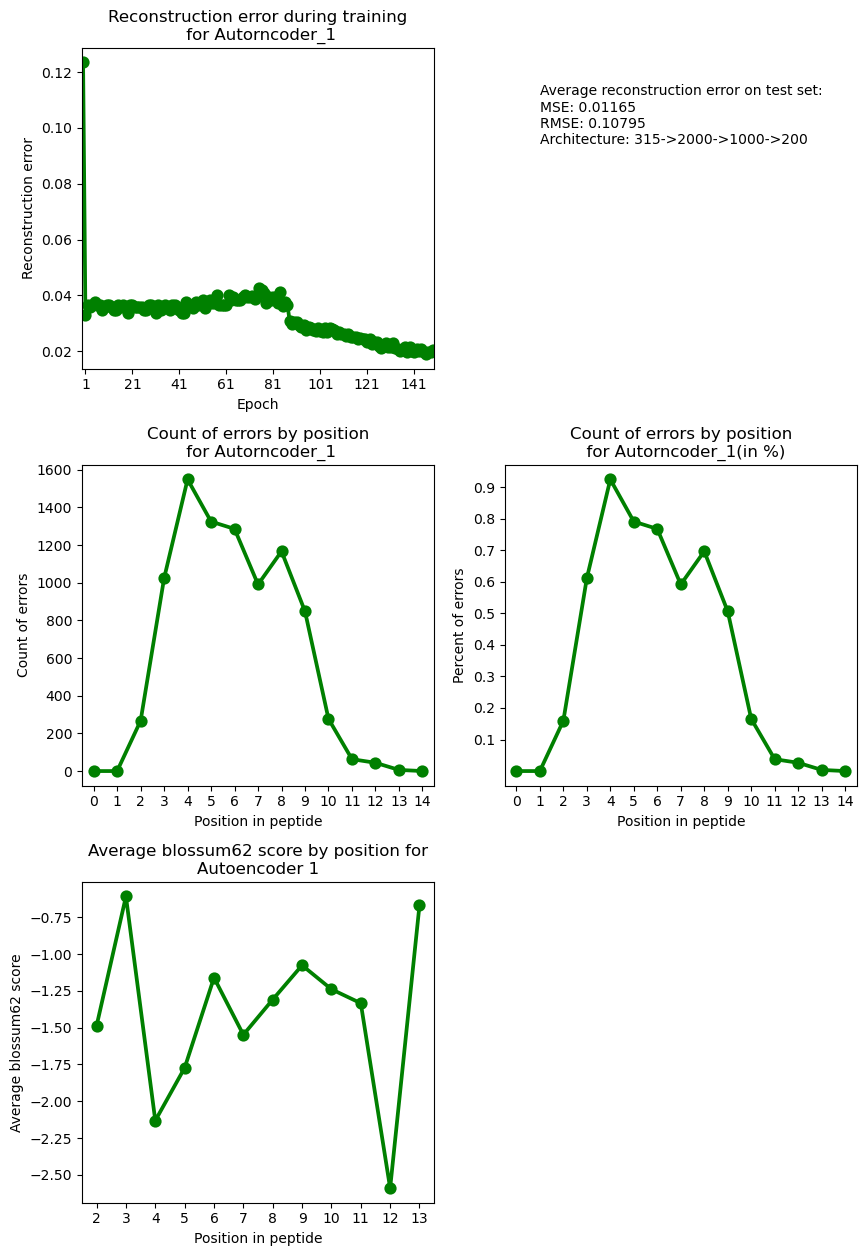

In [53]:
fig, axs = plt.subplots(3,2, figsize = [10, 15])
sns.pointplot(train_loss_avg_1, color = 'green', ax=axs[0, 0])
sns.pointplot(err_count, color = 'green', ax=axs[1, 0])
sns.pointplot(err_count/len(pep_test_list_bef_ae), color = 'green', ax=axs[1, 1])
axs[0, 0].set(xlabel='Epoch', ylabel='Reconstruction error', title = 'Reconstruction error during training\n for Autorncoder_1', xticks=[i for i in range(1, num_epochs, 20)])
axs[0, 1].set(frame_on=False)
axs[0, 1].set_xticks([])
axs[0, 1].set_yticks([])
axs[0, 1].text(x=0.1, y=0.7, s=f'Average reconstruction error on test set:\nMSE: {round(test_loss_avg_1, 5)}\nRMSE: {round(sqrt(test_loss_avg_1), 5)}\nArchitecture: {autoencoder_arch}')
axs[1, 0].set(xlabel='Position in peptide', ylabel='Count of errors', title='Count of errors by position\n for Autorncoder_1')
axs[1, 1].set(xlabel='Position in peptide', ylabel='Percent of errors', title='Count of errors by position\n  for Autorncoder_1(in %)', yticks=[i/10 for i in range(1, 10)])
sns.pointplot(x=avg_blos_score.keys(), y=avg_blos_score.values(), color='green', ax=axs[2,0])
axs[2, 0].set(xlabel='Position in peptide', ylabel='Average blossum62 score', title='Average blossum62 score by position for\nAutoencoder 1')
plt.subplots_adjust(wspace=0.2, hspace=0.3)
axs[2, 1].set(frame_on=False)
axs[2, 1].set_xticks([])
axs[2, 1].set_yticks([])
plt.show()
fig.savefig(f'./Results_one_hot/{numb}_{str(date.today())}_test_{autoencoder_arch}.pdf', format='pdf')


## Autoencoder_10 definition (315->2000->200)

In [54]:
numb += 1
autoencoder_arch = '315->2000->200'

class Encoder(nn.Module):
    def __init__(self):
        super(Encoder, self).__init__()
        self.fc1 = nn.Linear(in_features=len(AA_LIST)*len_seq, out_features=2000)
        self.fc2 = nn.Linear(in_features=2000, out_features=200)
            
    def forward(self, x):
        x = self.fc1(x)
        x = F.relu(x)
        x = self.fc2(x)
        return x

class Decoder(nn.Module):
    def __init__(self):
        super(Decoder, self).__init__()
        self.fc1 = nn.Linear(in_features=200, out_features=2000)
        self.fc2 = nn.Linear(in_features=2000, out_features=len(AA_LIST)*len_seq)
            
    def forward(self, x):
        x = self.fc1(x)
        x = F.relu(x)
        x = self.fc2(x)
        x = F.sigmoid(x)
        return x
    
class Autoencoder(nn.Module):
    def __init__(self):
        super(Autoencoder, self).__init__()
        self.encoder = Encoder()
        self.decoder = Decoder()
    
    def forward(self, x):
        latent = self.encoder(x)
        x_recon = self.decoder(latent)
        return x_recon
    
autoencoder_1 = Autoencoder()

autoencoder_1 = autoencoder_1.to(device)

num_params = sum(p.numel() for p in autoencoder_1.parameters() if p.requires_grad)
print('Number of parameters for One-hot encoding: %d' % num_params)

loss_function = nn.MSELoss()

optimizer = torch.optim.Adam(autoencoder_1.parameters(), lr = learning_rate, weight_decay = 1e-5)

Number of parameters for One-hot encoding: 2004500


### Train autoencoder

In [55]:
# set to training mode
autoencoder_1.train()

train_loss_avg_1 = []

print('Training ...')
for epoch in range(num_epochs):
    train_loss_avg_1.append(0)
    num_batches = 0
    
    for pep_batch, _ in oh_dl_train:
        
        pep_batch = pep_batch.to(device)

        pep_batch = pep_batch.reshape(-1, oh_matr_size)
        
        # autoencoder reconstruction
        pep_batch_recon = autoencoder_1(pep_batch)
        
        # reconstruction error
        loss = loss_function(pep_batch_recon, pep_batch)
        
        # backpropagation
        optimizer.zero_grad()
        loss.backward()
        
        # one step of the optmizer (using the gradients from backpropagation)
        optimizer.step()
        
        train_loss_avg_1[-1] += loss.item()
        num_batches += 1
        
    train_loss_avg_1[-1] /= num_batches
    if epoch % 10 == 0:
        print('Epoch [%d / %d] average reconstruction error: %f' % (epoch+1, num_epochs, train_loss_avg_1[-1]))
print('Train finished')

Training ...
Epoch [1 / 150] average reconstruction error: 0.124357
Epoch [11 / 150] average reconstruction error: 0.033518
Epoch [21 / 150] average reconstruction error: 0.035422
Epoch [31 / 150] average reconstruction error: 0.032567
Epoch [41 / 150] average reconstruction error: 0.035421
Epoch [51 / 150] average reconstruction error: 0.032982
Epoch [61 / 150] average reconstruction error: 0.022519
Epoch [71 / 150] average reconstruction error: 0.020164
Epoch [81 / 150] average reconstruction error: 0.015726
Epoch [91 / 150] average reconstruction error: 0.014250
Epoch [101 / 150] average reconstruction error: 0.015295
Epoch [111 / 150] average reconstruction error: 0.012613
Epoch [121 / 150] average reconstruction error: 0.012612
Epoch [131 / 150] average reconstruction error: 0.013133
Epoch [141 / 150] average reconstruction error: 0.013557
Train finished


### Evaluation

In [56]:
autoencoder_1.eval()

output = []
test_loss_avg_1, num_batches = 0, 0

# Прогоняем тестовую выборку через автоэнкодер
for (pep, _) in oh_dl_test:
    with torch.no_grad():
        pep = pep.reshape(-1, oh_matr_size)
        pep = pep.to(device)
        pep_recon = autoencoder_1(pep)
        loss = loss_function(pep_recon, pep)
        test_loss_avg_1 += loss.item()
        num_batches += 1
    output.append((pep, pep_recon))
test_loss_avg_1 /= num_batches


test_loss_avg_1 /= num_batches
print('Average reconstruction error: %f' % (test_loss_avg_1))

# Output выглядит странно это лист, состоящий из кортежей, каждый из которых относится к одному батчу. Т.е. ouput[0] - это кортеж из первого батча
# Далее каждый кортеж, состоит из двух тензоров: до и после энкодера. Тензоры в 2д формате.


# Создаём пустые(нулевые) массивы для one-hot петпидов до и после
pep_test_oh_bef = np.zeros((len(pep_test_list), len(pepcode.AA_LIST), len_seq), dtype = np.float32)
pep_test_oh_aft = np.zeros((len(pep_test_list), len(pepcode.AA_LIST), len_seq), dtype = np.float32)


# Переводим пептиды в np массив из output
pointer = 0
for i in range(num_batches):
    cur_batch_size = len(output[i][0])
    pep_test_oh_bef[pointer:pointer + cur_batch_size, :, : ] = output[i][0].reshape((cur_batch_size, len(AA_LIST), len_seq)).numpy(force=True)
    pep_test_oh_aft[pointer:pointer + cur_batch_size, :, : ] = output[i][1].reshape((cur_batch_size, len(AA_LIST), len_seq)).numpy(force=True)
    pointer += cur_batch_size
    

# Для каждого пептида после автоэнкодера приводим его к формату one-hot путем простанови 1 на место максимального веса в столбце
for i in range(pep_test_oh_aft.shape[0]):
    for j in range(len_seq):
        col_max = np.max(pep_test_oh_aft[i][:,j])
        for k in range(len(AA_LIST)):
            if pep_test_oh_aft[i][k][j] == col_max:
                pep_test_oh_aft[i][k][j] = 1.0
            else: 
                pep_test_oh_aft[i][k][j] = 0.0  

pep_test_list_bef_ae = []
pep_test_list_aft_ae = []

for i in range(pep_test_oh_aft.shape[0]):
    pep_test_list_bef_ae.append(pepcode.one_hot_decode(pep_test_oh_bef[i]))   
    pep_test_list_aft_ae.append(pepcode.one_hot_decode(pep_test_oh_aft[i]))

Average reconstruction error: 0.007314


### Biological evaluatiuon

In [57]:
err_count = np.zeros(len_seq, dtype = np.float32)
blos_score = np.zeros(len_seq, dtype = np.float32)

for i in range(len(pep_test_list_bef_ae)):
    for j in range(len_seq):
        if pep_test_list_bef_ae[i][j] != pep_test_list_aft_ae[i][j]:
            err_count[j] +=1
            blos_score[j] += pepcode.blosum_score(pep_test_list_bef_ae[i][j],pep_test_list_aft_ae[i][j])


avg_blos_score = {}
for i in range(len_seq):
    if err_count[i] !=0:
        avg_blos_score[i]=blos_score[i]/err_count[i]

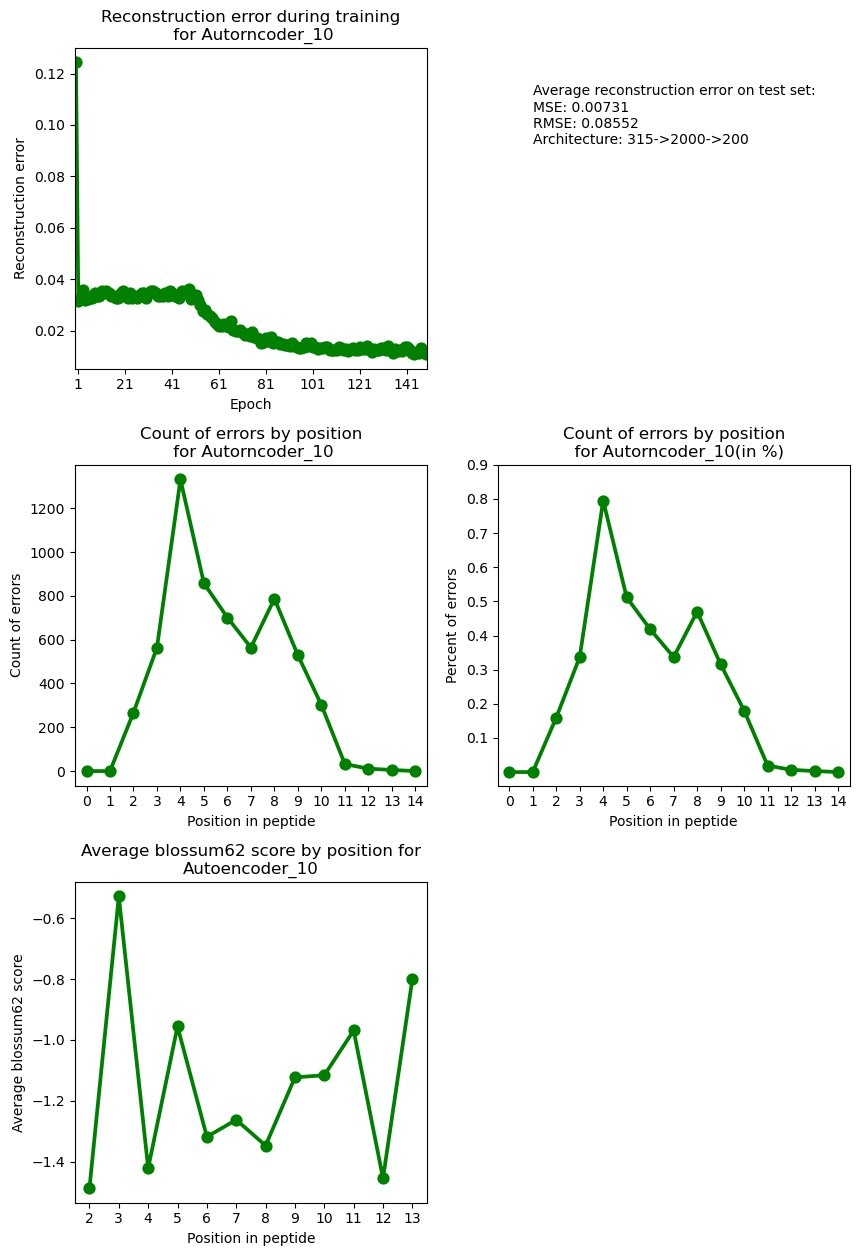

In [58]:
fig, axs = plt.subplots(3,2, figsize = [10, 15])
sns.pointplot(train_loss_avg_1, color = 'green', ax=axs[0, 0])
sns.pointplot(err_count, color = 'green', ax=axs[1, 0])
sns.pointplot(err_count/len(pep_test_list_bef_ae), color = 'green', ax=axs[1, 1])
axs[0, 0].set(xlabel='Epoch', ylabel='Reconstruction error', title=f'Reconstruction error during training\n for Autorncoder_{numb}', xticks=[i for i in range(1, num_epochs, 20)])
axs[0, 1].set(frame_on=False)
axs[0, 1].set_xticks([])
axs[0, 1].set_yticks([])
axs[0, 1].text(x=0.1, y=0.7, s=f'Average reconstruction error on test set:\nMSE: {round(test_loss_avg_1, 5)}\nRMSE: {round(sqrt(test_loss_avg_1), 5)}\nArchitecture: {autoencoder_arch}')
axs[1, 0].set(xlabel='Position in peptide', ylabel='Count of errors', title=f'Count of errors by position\n for Autorncoder_{numb}')
axs[1, 1].set(xlabel='Position in peptide', ylabel='Percent of errors', title=f'Count of errors by position\n  for Autorncoder_{numb}(in %)', yticks=[i/10 for i in range(1, 10)])
sns.pointplot(x=avg_blos_score.keys(), y=avg_blos_score.values(), color='green', ax=axs[2,0])
axs[2, 0].set(xlabel='Position in peptide', ylabel='Average blossum62 score', title=f'Average blossum62 score by position for\nAutoencoder_{numb}')
plt.subplots_adjust(wspace=0.2, hspace=0.3)
axs[2, 1].set(frame_on=False)
axs[2, 1].set_xticks([])
axs[2, 1].set_yticks([])
plt.show()
fig.savefig(f'./Results_one_hot/{numb}_{str(date.today())}_test_{autoencoder_arch}.pdf', format='pdf')
